In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

plt.rc('font', family='NanumGothic')

In [2]:
DATA_PATH = r"C:\Users\jaeyeon\OneDrive - Chonnam National University\미니프로젝트\백화점"

In [3]:
train_trans = pd.read_csv(f"{DATA_PATH}/store_train_transactions.csv")
test_trans = pd.read_csv(f"{DATA_PATH}/store_test_transactions.csv")
store_train = pd.read_csv(f"{DATA_PATH}/store_train.csv")
store_submission = pd.read_csv(f"{DATA_PATH}/store_submission.csv")

train_trans.shape , test_trans.shape, store_train.shape, store_submission.shape

((523105, 7), (441196, 7), (14940, 2), (12225, 2))

# 구매 관련 피처

In [4]:
train_trans["구매일시"] = pd.to_datetime(train_trans["구매일시"])
test_trans["구매일시"] = pd.to_datetime(test_trans["구매일시"])

In [5]:
train_ft = store_train.copy()
test_ft = store_submission.iloc[:,:1].copy()

In [6]:

agg_list = [
          ("방문지점수","nunique"),
          ('주구매지점', lambda x: x.mode()[0]),
    ]

tmp = train_trans.groupby('ID')["지점코드"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft.head()

,ID,target,방문지점수,주구매지점
0,train_0,1.0,2,A144000
1,train_1,1.0,3,A112000
2,train_2,0.0,2,A373000
3,train_3,0.0,3,A144000
4,train_4,0.0,2,A144000


In [7]:
agg_list = [
          ("방문지점수","nunique"),
          ('주구매지점', lambda x: x.mode()[0]),
    ]

tmp = test_trans.groupby('ID')["지점코드"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft.head()

,ID,방문지점수,주구매지점
0,test_0,1,A202000
1,test_1,2,A373000
2,test_2,1,A144000
3,test_3,1,A112000
4,test_4,3,A112000


In [8]:
#추가 구매지점 원핫코딩
from sklearn.preprocessing import OneHotEncoder


encoder=OneHotEncoder(handle_unknown='ignore')
col=['주구매지점']

coder=encoder.fit_transform(train_ft[col])
train_ft=pd.concat([train_ft,pd.DataFrame(coder.toarray(),columns=encoder.get_feature_names_out(col))],axis=1)
train_ft.drop('주구매지점',axis=1,inplace=True)
train_ft

,ID,target,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000
0,train_0,1.0,2,0.0,1.0,0.0,0.0
1,train_1,1.0,3,1.0,0.0,0.0,0.0
2,train_2,0.0,2,0.0,0.0,0.0,1.0
3,train_3,0.0,3,0.0,1.0,0.0,0.0
4,train_4,0.0,2,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
14935,train_14935,0.0,2,0.0,0.0,1.0,0.0
14936,train_14936,0.0,3,0.0,1.0,0.0,0.0
14937,train_14937,0.0,1,1.0,0.0,0.0,0.0
14938,train_14938,1.0,1,1.0,0.0,0.0,0.0


In [9]:
coder = encoder.transform(test_ft[col])

test_ft_encoded = pd.DataFrame(coder.toarray(), columns=encoder.get_feature_names_out(col), index=test_ft.index)
test_ft = pd.concat([test_ft, test_ft_encoded], axis=1)
test_ft.drop('주구매지점', axis=1, inplace=True)

test_ft.head()

,ID,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000
0,test_0,1,0.0,0.0,1.0,0.0
1,test_1,2,0.0,0.0,0.0,1.0
2,test_2,1,0.0,1.0,0.0,0.0
3,test_3,1,1.0,0.0,0.0,0.0
4,test_4,3,1.0,0.0,0.0,0.0


In [10]:

agg_list = [
            ('대분류_구매수', 'nunique'),
#             ('주구매_대분류', lambda x: x.mode()[0]),  ## 사용하지 않음
            ]

tmp = train_trans.groupby('ID')["대분류"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')

In [11]:
tmp = test_trans.groupby('ID')["대분류"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')

In [12]:
##추가
## 상위 구매목록 10를 뽑아서 유저의 대분류,중뷴류의 구매 일관성(유사도) 추출
## 대분류에 대해

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

rank_list = {
    '대분류': lambda x: x.value_counts().nlargest(10).index.tolist(),
    '중분류': lambda x: x.value_counts().nlargest(10).index.tolist()
}



grouped = train_trans.groupby('ID')[['대분류', '중분류']].agg(rank_list)

# Convert the lists of categories into single string per 'ID' for both '대분류' and '중분류'
grouped['대분류'] = grouped['대분류'].apply(lambda x: ' '.join(x))
grouped['중분류'] = grouped['중분류'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Concatenate '대분류' and '중분류' texts for vectorization
texts = grouped['대분류'].tolist() + grouped['중분류'].tolist()
tfidf_matrix = vectorizer.fit_transform(texts)

# Calculate similarity scores. Since the '대분류' and '중분류' are concatenated,
# the similarity is calculated between each '대분류' and its corresponding '중분류'
similarity_scores = cosine_similarity(tfidf_matrix[:len(grouped)], tfidf_matrix[len(grouped):])

# Add the similarity scores to the DataFrame
grouped['중분류_대분류_유사도'] = similarity_scores.diagonal()

grouped = grouped.reset_index()

# Now merge the similarity scores back into the original train_ft DataFrame using 'ID' as the key
train_ft = train_ft.merge(grouped[['ID', '중분류_대분류_유사도']], on='ID', how='left')

In [13]:
grouped = test_trans.groupby('ID')[['대분류', '중분류']].agg(rank_list)

# Convert the lists of categories into single string per 'ID' for both '대분류' and '중분류'
grouped['대분류'] = grouped['대분류'].apply(lambda x: ' '.join(x))
grouped['중분류'] = grouped['중분류'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Concatenate '대분류' and '중분류' texts for vectorization
texts = grouped['대분류'].tolist() + grouped['중분류'].tolist()
tfidf_matrix = vectorizer.fit_transform(texts)

# Calculate similarity scores. Since the '대분류' and '중분류' are concatenated,
# the similarity is calculated between each '대분류' and its corresponding '중분류'
similarity_scores = cosine_similarity(tfidf_matrix[:len(grouped)], tfidf_matrix[len(grouped):])

# Add the similarity scores to the DataFrame
grouped['중분류_대분류_유사도'] = similarity_scores.diagonal()

grouped = grouped.reset_index()

# Now merge the similarity scores back into the original train_ft DataFrame using 'ID' as the key
test_ft = test_ft.merge(grouped[['ID', '중분류_대분류_유사도']], on='ID', how='left')

In [14]:
#추가 
#대분류키워드 리스트
big_keywords=['가정용품파트', '공산품파트', '남성정장스포츠', '로얄부띠끄', '로얄부틱', '생식품', '생식품파트', '아동문화', '여성정장']

In [15]:

# 'train_trans' 데이터프레임에서 각 ID 별로 전체 구매 횟수 계산
total_purchases = train_trans.groupby('ID').size()

# 'train_trans' 데이터프레임에서 특정 대분류 상품의 구매 횟수 계산
keyword_purchases = train_trans[train_trans['대분류'].isin(big_keywords)].groupby('ID').size()

# 각 ID 별 특정 대분류 상품 구매 비율 계산
purchase_ratios = keyword_purchases / total_purchases

# 'train_ft' 데이터프레임에 '키워드/총구매' 열 추가
# 'ID' 열을 기준으로 'purchase_ratios'를 매핑
train_ft['대분류_키워드/총구매_비율'] = train_ft['ID'].map(purchase_ratios).fillna(0)


In [16]:

# 'train_trans' 데이터프레임에서 각 ID 별로 전체 구매 횟수 계산
total_purchases = test_trans.groupby('ID').size()

# 'train_trans' 데이터프레임에서 특정 대분류 상품의 구매 횟수 계산
keyword_purchases = test_trans[test_trans['대분류'].isin(big_keywords)].groupby('ID').size()

# 각 ID 별 특정 대분류 상품 구매 비율 계산
purchase_ratios = keyword_purchases / total_purchases

# 'train_ft' 데이터프레임에 '키워드/총구매' 열 추가
# 'ID' 열을 기준으로 'purchase_ratios'를 매핑
test_ft['대분류_키워드/총구매_비율'] = test_ft['ID'].map(purchase_ratios).fillna(0)


In [17]:
#추가 
#중분류 키워드리스트
middle_keywords=['GBR  지원','TV.VTR','TV_VTR','가스렌지','가전특정','건강용품', '건식품', '건어물', '곡물', '골프(LC)', '골프(NB)', '골프(국내)', '골프(단품)', '골프(수입)', '골프(용품)', '골프단품', '골프웨어', '과자', '교복행사', '구두수선', '국내부띠끄', '기타식품', '내셔날', '내셔널', '냉난방', '냉동식품', '냉장고_세탁기', '냉장식품', '니트', '단품(트래디셔널)', '단품행사', '디자이너니트',
'디자이너부띠끄', '디자이너숍', '디자이너캐릭터', '라디오.카세트', '라이센스', '레이디숍A', '레포츠',
'레포츠단품', '로얄부틱2F', '로얄수입행사', '마춤', '면류', '모피.피혁', '모피_피혁', '문구', '문화', '부띠끄', '부띠끄행사', '상품개발지원', '생선', '세탁기_냉장고', '소파', '소형가구(가구)', '쇼파', '수예',
 '수예침장','수예행사','수입_종합가구','수입구두','수입도자기','수입부띠끄','수입슈즈','수입캐주얼','수입피혁','슈즈','스포츠단품',
 '아동','아동단품',
 '아동복','아동잡화',
 '아동특선', '야채',
 '엘레강스','엘레강스부틱','영잡화',
 '완구','용기보증',
 '용품','원목(주니어)','유아','음료','의류기타',
 '인스탄트식품','임대골프', '잡화토탈',
 '전문가구(가구)',
'전화기',
'정육',
'조명',
 '조미료','종합_수입','주방용품',
 '지갑_벨트','직수입침구','청과','침구','침대',
 '카세트_전화기', '카페트',
 '카페트_대자리',
'캐쥬얼단품',
'크리스탈',
'타운','타운단품',
 '통병조림',
'통판',
 '트래디셔널캐쥬얼','특선행사','특판','페레  지원','피혁A행사','해외SHOP','행사_단품','행사구두(5F)','훼미닌부틱']

In [18]:
#중분류에 대해

agg_list = [
            ('중분류_구매수', 'nunique'),
#             ('주구매_중분류', lambda x: x.mode()[0]),
            ]

tmp = train_trans.groupby('ID')["중분류"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')

In [19]:
tmp = test_trans.groupby('ID')["중분류"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')

In [20]:

# 'train_trans' 데이터프레임에서 각 ID 별로 전체 구매 횟수 계산
total_purchases = train_trans.groupby('ID').size()

# 'train_trans' 데이터프레임에서 특정 대분류 상품의 구매 횟수 계산
keyword_purchases = train_trans[train_trans['중분류'].isin(middle_keywords)].groupby('ID').size()

# 각 ID 별 특정 대분류 상품 구매 비율 계산
purchase_ratios = keyword_purchases / total_purchases

# 'train_ft' 데이터프레임에 '키워드/총구매' 열 추가
# 'ID' 열을 기준으로 'purchase_ratios'를 매핑
train_ft['중분류_키워드/총구매_비율'] = train_ft['ID'].map(purchase_ratios).fillna(0)


In [21]:

# 'train_trans' 데이터프레임에서 각 ID 별로 전체 구매 횟수 계산
total_purchases = test_trans.groupby('ID').size()

# 'train_trans' 데이터프레임에서 특정 대분류 상품의 구매 횟수 계산
keyword_purchases = test_trans[test_trans['중분류'].isin(middle_keywords)].groupby('ID').size()

# 각 ID 별 특정 대분류 상품 구매 비율 계산
purchase_ratios = keyword_purchases / total_purchases

# 'train_ft' 데이터프레임에 '키워드/총구매' 열 추가
# 'ID' 열을 기준으로 'purchase_ratios'를 매핑
test_ft['중분류_키워드/총구매_비율'] = test_ft['ID'].map(purchase_ratios).fillna(0)


In [22]:
#추가
# 중분류가 0혹은 대분류가 0일 경우를 반영하기 위해 곱으로 계산하였음
#이는 키워드가 많이 들어갈 수록 큰수치를 부여하고 하나라도 작으면 작은 수치를 부여한다

train_ft['키워드_비율']=test_ft['대분류_키워드/총구매_비율'] *test_ft['중분류_키워드/총구매_비율'] 
test_ft['키워드_비율']=test_ft['대분류_키워드/총구매_비율']*test_ft['중분류_키워드/총구매_비율']
train_ft['키워드_비율'].fillna(0,inplace=True)
test_ft['키워드_비율'].fillna(0,inplace=True)

In [23]:
#추가
#키워드 대분류 총액

filtered_df = train_trans[train_trans['대분류'].isin(big_keywords)]

# Group by user ID and sum the purchase amounts for the filtered items
user_total_purchase = filtered_df.groupby('ID')['구매가격'].sum().reset_index()

# Rename the columns for clarity
user_total_purchase.columns = ['ID', '키워드_대분류_총액']

# Now user_total_purchase DataFrame will have the total purchase amount for each user based on the big keywords
train_ft = train_ft.merge(user_total_purchase, how='left')
train_ft['키워드_대분류_총액'].fillna(0,inplace=True)

In [24]:

# Filter the DataFrame for rows where the item description matches any of the big keywords
filtered_df = test_trans[test_trans['대분류'].isin(big_keywords)]

# Group by user ID and sum the purchase amounts for the filtered items
user_total_purchase = filtered_df.groupby('ID')['구매가격'].sum().reset_index()

# Rename the columns for clarity
user_total_purchase.columns = ['ID', '키워드_대분류_총액']

# Now user_total_purchase DataFrame will have the total purchase amount for each user based on the big keywords
test_ft = test_ft.merge(user_total_purchase, how='left')
test_ft['키워드_대분류_총액'].fillna(0,inplace=True)

In [25]:
#추가
#키워드 중분류 총액

filtered_df = train_trans[train_trans['중분류'].isin(middle_keywords)]

# Group by user ID and sum the purchase amounts for the filtered items
user_total_purchase = filtered_df.groupby('ID')['구매가격'].sum().reset_index()

# Rename the columns for clarity
user_total_purchase.columns = ['ID', '키워드_중분류_총액']

# Now user_total_purchase DataFrame will have the total purchase amount for each user based on the big keywords
train_ft = train_ft.merge(user_total_purchase, how='left')
train_ft['키워드_중분류_총액'].fillna(0,inplace=True)

In [26]:

# Filter the DataFrame for rows where the item description matches any of the big keywords
filtered_df = test_trans[test_trans['중분류'].isin(middle_keywords)]

# Group by user ID and sum the purchase amounts for the filtered items
user_total_purchase = filtered_df.groupby('ID')['구매가격'].sum().reset_index()

# Rename the columns for clarity
user_total_purchase.columns = ['ID', '키워드_중분류_총액']

# Now user_total_purchase DataFrame will have the total purchase amount for each user based on the big keywords
test_ft = test_ft.merge(user_total_purchase, how='left')
test_ft['키워드_중분류_총액'].fillna(0,inplace=True)

In [27]:
agg_list = [
        ('환불건수', lambda x: ( x < 0 ).sum() ),
    ]

tmp = train_trans.groupby(['ID'])["구매가격"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft['4회이상_환불여부'] = np.where(train_ft['환불건수'] >= 4, 1, 0)


In [28]:
tmp = test_trans.groupby(['ID'])["구매가격"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft['4회이상_환불여부'] = np.where(test_ft['환불건수'] >= 4, 1, 0)


In [29]:
agg_list = [
        ('총구매액',lambda x: x[x > 0].sum() ),
        ('구매건수', lambda x: x[x > 0].count() ),
        ('평균구매액', lambda x: x[x > 0].mean()),
        ('최대구매액', 'max'),
        ('최소구매액',lambda x: x[x > 0].min() ) ,
        ('환불금액',lambda x: x[x < 0].sum() ) ,
        ('구매금액표준편차',lambda x: x[x>0].std() ),
    ]

tmp = train_trans.groupby(['ID'])["구매가격"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft['구매금액표준편차'].fillna(0,inplace=True)
train_ft['확정구매']=train_ft['구매건수']-train_ft['환불건수']

In [30]:
tmp = test_trans.groupby(['ID'])["구매가격"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft['구매금액표준편차'].fillna(0,inplace=True)
test_ft['확정구매']=test_ft['구매건수']-test_ft['환불건수']

In [31]:
train_ft['총구매가격']=train_trans['ID'].map(train_trans.groupby('ID')['구매가격'].agg(lambda x :sum(x)).fillna(0))
test_ft['총구매가격']=test_trans['ID'].map(test_trans.groupby('ID')['구매가격'].agg(lambda x :sum(x)).fillna(0))

In [32]:
# 원본 데이터에 대해 qcut을 사용하여 4분위수에 따라 구간 나눔
train_ft['총구매가격_구간'] = pd.qcut(train_ft['총구매가격'], 4, labels=["Q1", "Q2", "Q3", "Q4"], duplicates='drop')
# train_ft.drop('총구매가격',axis=1,inplace=True)


In [33]:
# 원본 데이터에 대해 qcut을 사용하여 4분위수에 따라 구간 나눔
test_ft['총구매가격_구간'] = pd.qcut(train_ft['총구매가격'], 4, labels=["Q1", "Q2", "Q3", "Q4"], duplicates='drop')
# train_ft.drop('총구매가격',axis=1,inplace=True)


In [34]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 초기화
encoder = LabelEncoder()

# 변환할 열 선택
col = '총구매가격_구간'

# 라벨 인코딩 적용
train_ft[col] = encoder.fit_transform(train_ft[col])

# 결과 확인
train_ft.head()

,ID,target,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,...,총구매액,구매건수,평균구매액,최대구매액,최소구매액,환불금액,구매금액표준편차,확정구매,총구매가격,총구매가격_구간
0,train_0,1.0,2,0.0,1.0,0.0,0.0,9,0.0,0.600000,...,6718200,17,395188.235294,1236000,20000,-2517000,403660.245259,14,8261677,2
1,train_1,1.0,3,1.0,0.0,0.0,0.0,12,0.0,0.071429,...,5043025,42,120072.023810,698000,5600,0,126592.626144,42,8007823,2
2,train_2,0.0,2,0.0,0.0,0.0,1.0,14,0.0,0.078947,...,23207886,107,216896.130841,2770000,4400,-1072500,406609.265932,100,2889337,1
3,train_3,0.0,3,0.0,1.0,0.0,0.0,16,0.0,0.161137,...,38462562,197,195241.431472,1492000,10000,-2867800,236976.860907,183,8230625,2
4,train_4,0.0,2,0.0,1.0,0.0,0.0,8,0.0,0.419355,...,10943266,49,223331.959184,1204000,7640,-6954400,308503.944915,36,5446540,2


In [35]:
# 변환할 열 선택
col = '총구매가격_구간'

# 라벨 인코딩 적용
test_ft[col] = encoder.transform(test_ft[col])

# 결과 확인
test_ft.head()

,ID,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,중분류_구매수,...,총구매액,구매건수,평균구매액,최대구매액,최소구매액,환불금액,구매금액표준편차,확정구매,총구매가격,총구매가격_구간
0,test_0,1,0.0,0.0,1.0,0.0,5,0.0,0.142857,4,...,429579,7,61368.428571,110000,26643,0,32293.148313,7,14212711,2
1,test_1,2,0.0,0.0,0.0,1.0,3,0.0,0.000000,4,...,290600,4,72650.000000,118000,37600,0,33658.431336,4,5610071,2
2,test_2,1,0.0,1.0,0.0,0.0,3,0.0,0.000000,4,...,607000,5,121400.000000,326000,38000,0,117233.954126,5,1617000,1
3,test_3,1,1.0,0.0,0.0,0.0,5,0.0,0.000000,12,...,3397740,28,121347.857143,403000,7040,-1092000,122556.774972,24,12984985,2
4,test_4,3,1.0,0.0,0.0,0.0,6,0.0,0.000000,12,...,1940890,18,107827.222222,376000,16200,-372200,94997.232393,15,6202472,2


In [36]:
prod_list1 = ['생식품','생식품파트','공산품파트','공산품','잡화파트','가정용품파트','가정용품']
prod_list2 = ['아동_스포츠','아동_문화','케주얼_구두_아동','아동']
prod_list3 = ['여성캐쥬얼','패션잡화','여성정장','여성의류파트','여성캐주얼']
prod_list4 = ['남성정장스포츠','남성의류']
prod_list5 = ['스포츠캐쥬얼','영어덜트캐쥬얼','골프_유니캐쥬얼','잡화']
prod_list6 = ['로얄부띠끄','로얄부틱','명품잡화']
prod_list7 = ['영라이브','영플라자']

agg_list = [
    ('생활용품비율',lambda x : x.isin(prod_list1).mean() ),
    ('아동용품비율',lambda x : x.isin(prod_list2).mean() ),
    ('여성용품비율',lambda x : x.isin(prod_list3).mean() ),
    ('남성용품비율',lambda x : x.isin(prod_list4).mean() ),
    ('남녀공용용품비율',lambda x : x.isin(prod_list5).mean() ),
    ('명품비율',lambda x : x.isin(prod_list6).mean() ),
    ('기타비율',lambda x : x.isin(prod_list7).mean() )
]
tmp = train_trans.groupby('ID')["대분류"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft['생활_아동_남녀공용']=train_ft['생활용품비율']*train_ft['아동용품비율']*train_ft['남녀공용용품비율']
train_ft.shape


(14940, 35)

In [37]:
tmp = test_trans.groupby('ID')["대분류"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft['생활_아동_남녀공용']=test_ft['생활용품비율']*test_ft['아동용품비율']*test_ft['남녀공용용품비율']
test_ft.shape


(12225, 34)

# 시간 피처

In [38]:
#이거 상당히 중요한 피처임
#뽑은 것들 중 젤 잘 뽑아낸 것임
agg_worktime_visit = [
    ('근무시간_방문비율' , lambda x : np.mean((x.dt.hour >= 9) & (x.dt.hour <= 17)))
]

tmp = train_trans.groupby('ID')['구매일시'].agg(agg_worktime_visit).reset_index()

train_ft = train_ft.merge(tmp, how='left')

In [39]:
tmp = test_trans.groupby('ID')['구매일시'].agg(agg_worktime_visit).reset_index()

test_ft = test_ft.merge(tmp, how='left')

In [40]:
agg_list = [
        # 컬럼명, 집계 방식 튜플
        ('내점일수',lambda x : x.dt.date.nunique() ),
        ('구매주기',lambda x : ( x.max() - x.min() ).days / x.dt.date.nunique() ),
        ('주말방문비율', lambda x: np.mean(x.dt.dayofweek>4)),
        ('봄_구매비율', lambda x: np.mean(x.dt.month.isin([3,4,5]))),
        ('여름_구매비율', lambda x: np.mean(x.dt.month.isin([6,7,8]))),
        ('가을_구매비율', lambda x: np.mean(x.dt.month.isin([9,10,11]))),
        ('겨울_구매비율', lambda x: np.mean(x.dt.month.isin([1,2,12]))),
        ('주구매요일', lambda x: x.dt.dayofweek.value_counts().index[0]),
        ('주구매개월', lambda x: x.dt.month.value_counts().index[0]),
        ('거래개월수', lambda x: x.dt.month.nunique() ),
    ]

tmp = train_trans.groupby('ID')["구매일시"].agg(agg_list).reset_index()
train_ft = train_ft.merge(tmp, how='left')
train_ft['봄_가을구매비율']=train_ft['봄_구매비율']+train_ft['가을_구매비율']
train_ft['봄_가을_방문여부'] = np.where((train_ft['봄_구매비율'] > 0) & (train_ft['가을_구매비율'] > 0), 1, 0)
weekday_dummies = pd.get_dummies(train_ft['주구매요일'], prefix='주구매요일')
month_dummies = pd.get_dummies(train_ft['주구매개월'], prefix='주구매개월')

# 원-핫 인코딩된 데이터프레임 병합
train_ft = pd.concat([train_ft, weekday_dummies, month_dummies], axis=1)
train_ft.drop('주구매개월',axis=1,inplace=True)
train_ft.drop('주구매요일',axis=1,inplace=True)
train_ft.head()

,ID,target,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,...,주구매개월_3,주구매개월_4,주구매개월_5,주구매개월_6,주구매개월_7,주구매개월_8,주구매개월_9,주구매개월_10,주구매개월_11,주구매개월_12
0,train_0,1.0,2,0.0,1.0,0.0,0.0,9,0.0,0.600000,...,0,0,0,0,0,0,0,0,0,1
1,train_1,1.0,3,1.0,0.0,0.0,0.0,12,0.0,0.071429,...,0,0,0,0,0,0,1,0,0,0
2,train_2,0.0,2,0.0,0.0,0.0,1.0,14,0.0,0.078947,...,0,1,0,0,0,0,0,0,0,0
3,train_3,0.0,3,0.0,1.0,0.0,0.0,16,0.0,0.161137,...,0,1,0,0,0,0,0,0,0,0
4,train_4,0.0,2,0.0,1.0,0.0,0.0,8,0.0,0.419355,...,0,0,0,0,1,0,0,0,0,0


In [41]:
tmp = test_trans.groupby('ID')["구매일시"].agg(agg_list).reset_index()
test_ft = test_ft.merge(tmp, how='left')
test_ft['봄_가을구매비율']=test_ft['봄_구매비율']+test_ft['가을_구매비율']
test_ft['봄_가을_방문여부'] = np.where((test_ft['봄_구매비율'] > 0) & (test_ft['가을_구매비율'] > 0), 1, 0)
weekday_dummies = pd.get_dummies(test_ft['주구매요일'], prefix='주구매요일')
month_dummies = pd.get_dummies(test_ft['주구매개월'], prefix='주구매개월')

# 원-핫 인코딩된 데이터프레임 병합
test_ft = pd.concat([test_ft, weekday_dummies, month_dummies], axis=1)
test_ft.drop('주구매개월',axis=1,inplace=True)
test_ft.drop('주구매요일',axis=1,inplace=True)
test_ft.head()

,ID,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,중분류_구매수,...,주구매개월_3,주구매개월_4,주구매개월_5,주구매개월_6,주구매개월_7,주구매개월_8,주구매개월_9,주구매개월_10,주구매개월_11,주구매개월_12
0,test_0,1,0.0,0.0,1.0,0.0,5,0.0,0.142857,4,...,0,0,0,0,0,0,0,1,0,0
1,test_1,2,0.0,0.0,0.0,1.0,3,0.0,0.000000,4,...,0,0,0,0,0,0,0,1,0,0
2,test_2,1,0.0,1.0,0.0,0.0,3,0.0,0.000000,4,...,0,0,0,0,0,1,0,0,0,0
3,test_3,1,1.0,0.0,0.0,0.0,5,0.0,0.000000,12,...,0,0,0,0,1,0,0,0,0,0
4,test_4,3,1.0,0.0,0.0,0.0,6,0.0,0.000000,12,...,0,0,1,0,0,0,0,0,0,0


In [42]:
def search_season(data):
    tmp=data.groupby('ID')[['봄_구매비율','여름_구매비율','가을_구매비율','겨울_구매비율']].max().idxmax(axis=1).apply(lambda x: x.split('_')[0])
    tmp=tmp.reset_index().rename(columns={0:'주구매계절'})
#     count_dict = tmp["주구매계절"].value_counts().to_dict()
#     tmp["주구매계절"]=tmp["주구매계절"].map(count_dict)
    return tmp

train_ft=train_ft.merge(search_season(train_ft), how='left')

In [43]:
def search_season(data):
    tmp=data.groupby('ID')[['봄_구매비율','여름_구매비율','가을_구매비율','겨울_구매비율']].max().idxmax(axis=1).apply(lambda x: x.split('_')[0])
    tmp=tmp.reset_index().rename(columns={0:'주구매계절'})
#     count_dict = tmp["주구매계절"].value_counts().to_dict()
#     tmp["주구매계절"]=tmp["주구매계절"].map(count_dict)
    return tmp

test_ft=test_ft.merge(search_season(test_ft), how='left')

In [44]:
encoder=OneHotEncoder(handle_unknown='ignore')

col=['주구매계절']

encoded_train=encoder.fit_transform(train_ft[col])

encoded_train_df = pd.DataFrame(encoded_train.toarray(), columns=encoder.get_feature_names_out(col))
train_ft = pd.concat([train_ft,encoded_train_df],axis=1)
train_ft.drop('주구매계절',axis=1,inplace=True)

In [45]:
col=['주구매계절']

encoded_train=encoder.transform(test_ft[col])

encoded_train_df = pd.DataFrame(encoded_train.toarray(), columns=encoder.get_feature_names_out(col))
test_ft = pd.concat([test_ft,encoded_train_df],axis=1)
test_ft.drop('주구매계절',axis=1,inplace=True)

In [46]:
train_ft['계절_구매비율_곱']=train_ft['가을_구매비율']*train_ft['여름_구매비율']*train_ft['봄_구매비율']*train_ft['겨울_구매비율']
test_ft['계절_구매비율_곱']=test_ft['가을_구매비율']*test_ft['여름_구매비율']*test_ft['봄_구매비율']*test_ft['겨울_구매비율']

In [47]:
train_trans["구매날짜"] = train_trans["구매일시"].dt.date
tmp = train_trans.groupby(["ID","구매날짜"])["구매일시"].agg(lambda x : (x.max() - x.min()).total_seconds() ).reset_index()

agg_list = [
    ("체류시간_max","max"),
    ("체류시간_min","min"),
    ("체류시간_std","std"),
    ("체류시간_mean","mean"),
    ("체류시간_sum","sum")
]
tmp2 = tmp.groupby("ID")["구매일시"].agg(agg_list).reset_index()
train_ft = pd.merge(train_ft, tmp2, how="left", on="ID")
train_ft['체류시간_std'].fillna(0,inplace=True)
train_ft.shape

(14940, 75)

In [48]:
test_trans["구매날짜"] = test_trans["구매일시"].dt.date
tmp = test_trans.groupby(["ID","구매날짜"])["구매일시"].agg(lambda x : (x.max() - x.min()).total_seconds() ).reset_index()

agg_list = [
    ("체류시간_max","max"),
    ("체류시간_min","min"),
    ("체류시간_std","std"),
    ("체류시간_mean","mean"),
    ("체류시간_sum","sum")
]
tmp2 = tmp.groupby("ID")["구매일시"].agg(agg_list).reset_index()
test_ft = pd.merge(test_ft, tmp2, how="left", on="ID")
test_ft['체류시간_std'].fillna(0,inplace=True)
test_ft.shape

(12225, 74)

In [49]:
train_ft.to_excel('트레인최종피처.xlsx',index=False)
test_ft.to_excel('테스트최종피처.xlsx',index=False)

# ===========================================

In [50]:
train_ft.columns

Index(['ID', 'target', '방문지점수', '주구매지점_A112000', '주구매지점_A144000',
       '주구매지점_A202000', '주구매지점_A373000', '대분류_구매수', '중분류_대분류_유사도',
       '대분류_키워드/총구매_비율', '중분류_구매수', '중분류_키워드/총구매_비율', '키워드_비율', '키워드_대분류_총액',
       '키워드_중분류_총액', '환불건수', '4회이상_환불여부', '총구매액', '구매건수', '평균구매액', '최대구매액',
       '최소구매액', '환불금액', '구매금액표준편차', '확정구매', '총구매가격', '총구매가격_구간', '생활용품비율',
       '아동용품비율', '여성용품비율', '남성용품비율', '남녀공용용품비율', '명품비율', '기타비율', '생활_아동_남녀공용',
       '근무시간_방문비율', '내점일수', '구매주기', '주말방문비율', '봄_구매비율', '여름_구매비율', '가을_구매비율',
       '겨울_구매비율', '거래개월수', '봄_가을구매비율', '봄_가을_방문여부', '주구매요일_0', '주구매요일_1',
       '주구매요일_2', '주구매요일_3', '주구매요일_4', '주구매요일_5', '주구매요일_6', '주구매개월_1',
       '주구매개월_2', '주구매개월_3', '주구매개월_4', '주구매개월_5', '주구매개월_6', '주구매개월_7',
       '주구매개월_8', '주구매개월_9', '주구매개월_10', '주구매개월_11', '주구매개월_12', '주구매계절_가을',
       '주구매계절_겨울', '주구매계절_봄', '주구매계절_여름', '계절_구매비율_곱', '체류시간_max', '체류시간_min',
       '체류시간_std', '체류시간_mean', '체류시간_sum'],
      dtype='object')

In [51]:
train_ft['대분류_선호도_지수'] = train_ft['대분류_구매수'] * train_ft['중분류_대분류_유사도']
train_ft['중분류_선호도_지수'] = train_ft['중분류_구매수'] * train_ft['중분류_대분류_유사도']
train_ft.head()

,ID,target,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,...,주구매계절_봄,주구매계절_여름,계절_구매비율_곱,체류시간_max,체류시간_min,체류시간_std,체류시간_mean,체류시간_sum,대분류_선호도_지수,중분류_선호도_지수
0,train_0,1.0,2,0.0,1.0,0.0,0.0,9,0.0,0.600000,...,0.0,0.0,0.001500,2220.0,0.0,754.405244,474.545455,5220.0,0.0,0.0
1,train_1,1.0,3,1.0,0.0,0.0,0.0,12,0.0,0.071429,...,1.0,0.0,0.002531,14580.0,0.0,3399.603338,2028.571429,42600.0,0.0,0.0
2,train_2,0.0,2,0.0,0.0,0.0,1.0,14,0.0,0.078947,...,1.0,0.0,0.002510,16680.0,0.0,3331.458789,1549.285714,86760.0,0.0,0.0
3,train_3,0.0,3,0.0,1.0,0.0,0.0,16,0.0,0.161137,...,1.0,0.0,0.003297,25800.0,0.0,6121.776919,3161.086957,290820.0,0.0,0.0
4,train_4,0.0,2,0.0,1.0,0.0,0.0,8,0.0,0.419355,...,0.0,1.0,0.000936,18000.0,0.0,3713.592497,1800.000000,48600.0,0.0,0.0


In [52]:
test_ft['대분류_선호도_지수'] = test_ft['대분류_구매수'] * test_ft['중분류_대분류_유사도']
test_ft['중분류_선호도_지수'] = test_ft['중분류_구매수'] * test_ft['중분류_대분류_유사도']
test_ft.head()

,ID,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,중분류_구매수,...,주구매계절_봄,주구매계절_여름,계절_구매비율_곱,체류시간_max,체류시간_min,체류시간_std,체류시간_mean,체류시간_sum,대분류_선호도_지수,중분류_선호도_지수
0,test_0,1,0.0,0.0,1.0,0.0,5,0.0,0.142857,4,...,0.0,0.0,0.000000,4200.0,0.0,1819.890107,1080.000000,5400.0,0.0,0.0
1,test_1,2,0.0,0.0,0.0,1.0,3,0.0,0.000000,4,...,0.0,0.0,0.000000,600.0,0.0,346.410162,200.000000,600.0,0.0,0.0
2,test_2,1,0.0,1.0,0.0,0.0,3,0.0,0.000000,4,...,0.0,1.0,0.000000,600.0,600.0,0.000000,600.000000,1200.0,0.0,0.0
3,test_3,1,1.0,0.0,0.0,0.0,5,0.0,0.000000,12,...,0.0,1.0,0.001259,7800.0,0.0,2197.548634,1057.500000,16920.0,0.0,0.0
4,test_4,3,1.0,0.0,0.0,0.0,6,0.0,0.000000,12,...,1.0,0.0,0.002468,7200.0,0.0,2527.686689,1653.333333,14880.0,0.0,0.0


In [53]:
train_ft['대분류_구매수_평균'] = train_ft['대분류_구매수'].mean()
train_ft['대분류_구매수_표준편차'] = train_ft['대분류_구매수'].std()
train_ft['중분류_구매수_평균'] = train_ft['중분류_구매수'].mean()
train_ft['중분류_구매수_평균'] = train_ft['중분류_구매수'].std()

In [54]:
test_ft['대분류_구매수_평균'] = test_ft['대분류_구매수'].mean()
test_ft['대분류_구매수_표준편차'] = test_ft['대분류_구매수'].std()
test_ft['중분류_구매수_평균'] = test_ft['중분류_구매수'].mean()
test_ft['중분류_구매수_평균'] = test_ft['중분류_구매수'].std()

In [55]:
# Recreate 주구매지점_구매빈도 features with the new logic
for column in train_ft.columns:
    if '주구매지점' in column:
        # Assuming '중분류_구매수' is a feature that exists and is analogous to '대분류_구매수'
        # If '중분류_구매수' does not exist in the dataset, this will raise an error
        # This code will create two features for each 주구매지점: one with 대분류_구매수 and one with 중분류_구매수
        train_ft[f'{column}_대분류_구매빈도'] = train_ft[column] * train_ft['대분류_구매수']
        train_ft[f'{column}_중분류_구매빈도'] = train_ft[column] * train_ft['중분류_구매수'] # Using .get to avoid KeyError if the column doesn't exist

# Show the updated dataframe
train_ft.head()


,ID,target,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,...,대분류_구매수_표준편차,중분류_구매수_평균,주구매지점_A112000_대분류_구매빈도,주구매지점_A112000_중분류_구매빈도,주구매지점_A144000_대분류_구매빈도,주구매지점_A144000_중분류_구매빈도,주구매지점_A202000_대분류_구매빈도,주구매지점_A202000_중분류_구매빈도,주구매지점_A373000_대분류_구매빈도,주구매지점_A373000_중분류_구매빈도
0,train_0,1.0,2,0.0,1.0,0.0,0.0,9,0.0,0.600000,...,3.480742,10.94972,0.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0
1,train_1,1.0,3,1.0,0.0,0.0,0.0,12,0.0,0.071429,...,3.480742,10.94972,12.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train_2,0.0,2,0.0,0.0,0.0,1.0,14,0.0,0.078947,...,3.480742,10.94972,0.0,0.0,0.0,0.0,0.0,0.0,14.0,35.0
3,train_3,0.0,3,0.0,1.0,0.0,0.0,16,0.0,0.161137,...,3.480742,10.94972,0.0,0.0,16.0,60.0,0.0,0.0,0.0,0.0
4,train_4,0.0,2,0.0,1.0,0.0,0.0,8,0.0,0.419355,...,3.480742,10.94972,0.0,0.0,8.0,24.0,0.0,0.0,0.0,0.0


In [56]:
# Recreate 주구매지점_구매빈도 features with the new logic
for column in test_ft.columns:
    if '주구매지점' in column:
        # Assuming '중분류_구매수' is a feature that exists and is analogous to '대분류_구매수'
        # If '중분류_구매수' does not exist in the dataset, this will raise an error
        # This code will create two features for each 주구매지점: one with 대분류_구매수 and one with 중분류_구매수
        test_ft[f'{column}_대분류_구매빈도'] = test_ft[column] * test_ft['대분류_구매수']
        test_ft[f'{column}_중분류_구매빈도'] = test_ft[column] * test_ft['중분류_구매수'] # Using .get to avoid KeyError if the column doesn't exist

# Show the updated dataframe
test_ft.head()


,ID,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,중분류_구매수,...,대분류_구매수_표준편차,중분류_구매수_평균,주구매지점_A112000_대분류_구매빈도,주구매지점_A112000_중분류_구매빈도,주구매지점_A144000_대분류_구매빈도,주구매지점_A144000_중분류_구매빈도,주구매지점_A202000_대분류_구매빈도,주구매지점_A202000_중분류_구매빈도,주구매지점_A373000_대분류_구매빈도,주구매지점_A373000_중분류_구매빈도
0,test_0,1,0.0,0.0,1.0,0.0,5,0.0,0.142857,4,...,3.492675,10.934849,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0
1,test_1,2,0.0,0.0,0.0,1.0,3,0.0,0.000000,4,...,3.492675,10.934849,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
2,test_2,1,0.0,1.0,0.0,0.0,3,0.0,0.000000,4,...,3.492675,10.934849,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0
3,test_3,1,1.0,0.0,0.0,0.0,5,0.0,0.000000,12,...,3.492675,10.934849,5.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
4,test_4,3,1.0,0.0,0.0,0.0,6,0.0,0.000000,12,...,3.492675,10.934849,6.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# 근무시간 중 특정 키워드 구매 건수 계산
# 위에 제공된 키워드 리스트 사용
# 근무시간에 구매한 트랜잭션 필터링
worktime_purchases = train_trans[train_trans['구매일시'].dt.hour.between(9, 17)]
# 각 ID별로 근무시간 중 특정 키워드를 포함하는 구매 건수 계산
keyword_purchase_counts = worktime_purchases[worktime_purchases['대분류'].isin(big_keywords)]
keyword_purchase_counts = keyword_purchase_counts.groupby('ID').size().reset_index(name='근무시간_키워드_대분류_구매건수')
# 결과를 train_ft 데이터프레임에 병합
train_ft = train_ft.merge(keyword_purchase_counts, how='left', on='ID')

# 결측치를 0으로 채우기 (구매 이력이 없는 경우)
train_ft['근무시간_키워드_대분류_구매건수'].fillna(0, inplace=True)

# 최종 train_ft 데이터프레임 확인
train_ft.head()


,ID,target,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,...,중분류_구매수_평균,주구매지점_A112000_대분류_구매빈도,주구매지점_A112000_중분류_구매빈도,주구매지점_A144000_대분류_구매빈도,주구매지점_A144000_중분류_구매빈도,주구매지점_A202000_대분류_구매빈도,주구매지점_A202000_중분류_구매빈도,주구매지점_A373000_대분류_구매빈도,주구매지점_A373000_중분류_구매빈도,근무시간_키워드_대분류_구매건수
0,train_0,1.0,2,0.0,1.0,0.0,0.0,9,0.0,0.600000,...,10.94972,0.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,10.0
1,train_1,1.0,3,1.0,0.0,0.0,0.0,12,0.0,0.071429,...,10.94972,12.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,train_2,0.0,2,0.0,0.0,0.0,1.0,14,0.0,0.078947,...,10.94972,0.0,0.0,0.0,0.0,0.0,0.0,14.0,35.0,9.0
3,train_3,0.0,3,0.0,1.0,0.0,0.0,16,0.0,0.161137,...,10.94972,0.0,0.0,16.0,60.0,0.0,0.0,0.0,0.0,28.0
4,train_4,0.0,2,0.0,1.0,0.0,0.0,8,0.0,0.419355,...,10.94972,0.0,0.0,8.0,24.0,0.0,0.0,0.0,0.0,18.0


In [58]:
# 근무시간 중 특정 키워드 구매 건수 계산
# 위에 제공된 키워드 리스트 사용
# 근무시간에 구매한 트랜잭션 필터링
worktime_purchases = train_trans[train_trans['구매일시'].dt.hour.between(9, 17)]
# 각 ID별로 근무시간 중 특정 키워드를 포함하는 구매 건수 계산
keyword_purchase_counts = worktime_purchases[worktime_purchases['중분류'].isin(middle_keywords)]
keyword_purchase_counts = keyword_purchase_counts.groupby('ID').size().reset_index(name='근무시간_키워드_중분류_구매건수')
# 결과를 train_ft 데이터프레임에 병합
train_ft = train_ft.merge(keyword_purchase_counts, how='left', on='ID')

# 결측치를 0으로 채우기 (구매 이력이 없는 경우)
train_ft['근무시간_키워드_중분류_구매건수'].fillna(0, inplace=True)

# 최종 train_ft 데이터프레임 확인
train_ft.head()


,ID,target,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,...,주구매지점_A112000_대분류_구매빈도,주구매지점_A112000_중분류_구매빈도,주구매지점_A144000_대분류_구매빈도,주구매지점_A144000_중분류_구매빈도,주구매지점_A202000_대분류_구매빈도,주구매지점_A202000_중분류_구매빈도,주구매지점_A373000_대분류_구매빈도,주구매지점_A373000_중분류_구매빈도,근무시간_키워드_대분류_구매건수,근무시간_키워드_중분류_구매건수
0,train_0,1.0,2,0.0,1.0,0.0,0.0,9,0.0,0.600000,...,0.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,10.0,10.0
1,train_1,1.0,3,1.0,0.0,0.0,0.0,12,0.0,0.071429,...,12.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
2,train_2,0.0,2,0.0,0.0,0.0,1.0,14,0.0,0.078947,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,35.0,9.0,30.0
3,train_3,0.0,3,0.0,1.0,0.0,0.0,16,0.0,0.161137,...,0.0,0.0,16.0,60.0,0.0,0.0,0.0,0.0,28.0,25.0
4,train_4,0.0,2,0.0,1.0,0.0,0.0,8,0.0,0.419355,...,0.0,0.0,8.0,24.0,0.0,0.0,0.0,0.0,18.0,30.0


In [59]:
# 근무시간 중 특정 키워드 구매 건수 계산
# 위에 제공된 키워드 리스트 사용
# 근무시간에 구매한 트랜잭션 필터링
worktime_purchases = test_trans[test_trans['구매일시'].dt.hour.between(9, 17)]
# 각 ID별로 근무시간 중 특정 키워드를 포함하는 구매 건수 계산
keyword_purchase_counts = worktime_purchases[worktime_purchases['대분류'].isin(big_keywords)]
keyword_purchase_counts = keyword_purchase_counts.groupby('ID').size().reset_index(name='근무시간_키워드_대분류_구매건수')
# 결과를 train_ft 데이터프레임에 병합
test_ft = test_ft.merge(keyword_purchase_counts, how='left', on='ID')

# 결측치를 0으로 채우기 (구매 이력이 없는 경우)
test_ft['근무시간_키워드_대분류_구매건수'].fillna(0, inplace=True)

# 최종 train_ft 데이터프레임 확인
test_ft.head()


,ID,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,중분류_구매수,...,중분류_구매수_평균,주구매지점_A112000_대분류_구매빈도,주구매지점_A112000_중분류_구매빈도,주구매지점_A144000_대분류_구매빈도,주구매지점_A144000_중분류_구매빈도,주구매지점_A202000_대분류_구매빈도,주구매지점_A202000_중분류_구매빈도,주구매지점_A373000_대분류_구매빈도,주구매지점_A373000_중분류_구매빈도,근무시간_키워드_대분류_구매건수
0,test_0,1,0.0,0.0,1.0,0.0,5,0.0,0.142857,4,...,10.934849,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,1.0
1,test_1,2,0.0,0.0,0.0,1.0,3,0.0,0.000000,4,...,10.934849,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0
2,test_2,1,0.0,1.0,0.0,0.0,3,0.0,0.000000,4,...,10.934849,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0
3,test_3,1,1.0,0.0,0.0,0.0,5,0.0,0.000000,12,...,10.934849,5.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,test_4,3,1.0,0.0,0.0,0.0,6,0.0,0.000000,12,...,10.934849,6.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# 근무시간 중 특정 키워드 구매 건수 계산
# 위에 제공된 키워드 리스트 사용
# 근무시간에 구매한 트랜잭션 필터링
worktime_purchases = test_trans[test_trans['구매일시'].dt.hour.between(9, 17)]
# 각 ID별로 근무시간 중 특정 키워드를 포함하는 구매 건수 계산
keyword_purchase_counts = worktime_purchases[worktime_purchases['중분류'].isin(middle_keywords)]
keyword_purchase_counts = keyword_purchase_counts.groupby('ID').size().reset_index(name='근무시간_키워드_중분류_구매건수')
# 결과를 train_ft 데이터프레임에 병합
test_ft = test_ft.merge(keyword_purchase_counts, how='left', on='ID')

# 결측치를 0으로 채우기 (구매 이력이 없는 경우)
test_ft['근무시간_키워드_중분류_구매건수'].fillna(0, inplace=True)

# 최종 train_ft 데이터프레임 확인
test_ft.head()


,ID,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,중분류_구매수,...,주구매지점_A112000_대분류_구매빈도,주구매지점_A112000_중분류_구매빈도,주구매지점_A144000_대분류_구매빈도,주구매지점_A144000_중분류_구매빈도,주구매지점_A202000_대분류_구매빈도,주구매지점_A202000_중분류_구매빈도,주구매지점_A373000_대분류_구매빈도,주구매지점_A373000_중분류_구매빈도,근무시간_키워드_대분류_구매건수,근무시간_키워드_중분류_구매건수
0,test_0,1,0.0,0.0,1.0,0.0,5,0.0,0.142857,4,...,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,1.0,6.0
1,test_1,2,0.0,0.0,0.0,1.0,3,0.0,0.000000,4,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0
2,test_2,1,0.0,1.0,0.0,0.0,3,0.0,0.000000,4,...,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,test_3,1,1.0,0.0,0.0,0.0,5,0.0,0.000000,12,...,5.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,test_4,3,1.0,0.0,0.0,0.0,6,0.0,0.000000,12,...,6.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [61]:
train_ft['근무시간_키워드_구매건수']=train_ft['근무시간_키워드_중분류_구매건수']+train_ft['근무시간_키워드_대분류_구매건수']
test_ft['근무시간_키워드_구매건수']=test_ft['근무시간_키워드_중분류_구매건수']+test_ft['근무시간_키워드_대분류_구매건수']

In [ ]:
# 중분류 피벗 테이블 추가
tmp = train_trans.pivot_table(index = ['ID'],
                                columns = ['중분류'],
                                values = ['구매가격'],
                                aggfunc = np.sum)
tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)
tmp.columns = ['_'.join(t) for t in tmp.columns]
tmp.rename(columns = {'ID_':'ID'},inplace = True)


train_ft = pd.merge(train_ft,tmp,how = 'left',on = 'ID')

tmp = test_trans.pivot_table(index = ['ID'],
                                columns = ['중분류'],
                                values = ['구매가격'],
                                aggfunc = np.sum)

tmp = tmp.reset_index()
tmp.fillna(0,inplace = True)
tmp.columns = ['_'.join(t) for t in tmp.columns]
tmp.rename(columns = {'ID_':'ID'},inplace = True)

test_ft = pd.merge(test_ft,tmp,how = 'left',on = 'ID')

train_ft.drop(columns = ['구매가격_특판'],inplace = True) # test에 특가 없음

train_ft.shape,test_ft.shape

# =====================튜닝 및 적합=======================

In [125]:
X = train_ft.drop(['ID', 'target'], axis=1)
y= train_ft['target']
Y = test_ft.drop(['ID'], axis=1)

In [73]:
# from sklearn.preprocessing import MinMaxScaler

# # 스케일러 초기화
# scaler = MinMaxScaler()

# #트레인 데이터에 스케일링 적용
# X_scaled = scaler.fit_transform(X)

# # 테스트 데이터에 스케일링 적용
# Y_scaled = scaler.transform(Y)

# # 결과를 데이터프레임으로 변환 (옵션)
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns)


In [126]:
from sklearn.preprocessing import RobustScaler

# 스케일러 초기화
scaler = RobustScaler()

# 트레인 데이터에 스케일링 적용
X_scaled = scaler.fit_transform(X)

# 테스트 데이터에 스케일링 적용
Y_scaled = scaler.transform(Y)

# 결과를 데이터프레임으로 변환 (옵션)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns)


In [127]:
# from sklearn.preprocessing import StandardScaler

# # 스케일러 초기화
# scaler = StandardScaler()

# # 트레인 데이터에 스케일링 적용
# X_scaled = scaler.fit_transform(X)
# # 테스트 데이터에 스케일링 적용
# # Y_scaled = scaler.transform(Y)

# # 결과를 데이터프레임으로 변환 (옵션)
# import pandas as pd
# X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# Y_scaled = pd.DataFrame(Y_scaled, columns=Y.columns)

In [128]:
X_scaled['target']=train_ft['target']

In [ ]:


#제출 모델

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.metrics import classification_report

cv=KFold(n_splits=5,random_state=42,shuffle=True)

lr = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


lr.fit(X_scaled, y)


# 최적의 모델로 예측 및 평가
cv_scores = cross_val_score(lr, X_scaled, y, cv=cv)

print("Cross-Validated Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


In [ ]:
lr.predict_proba(Y_scaled)
pred=lr.predict_proba(Y_scaled)

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit
submit.to_csv("양태성12차.csv",index=False)

In [ ]:
X_scaled.to_excel(excel_writer = f'{DATA_PATH}X_scaled.xlsx')
Y_scaled.to_excel(excel_writer = f'{DATA_PATH}Y_scaled.xlsx')

In [ ]:
## 아래는 피벗 테이블 추가 안된 튜닝 모델들

In [129]:
from pycaret.classification import *
# include=['lightgbm', 'xgboost', 'catboost', 'gbc', 'rf', 'et', 'ada', 'dt', 'knn', 'nb', 'lr']
# PyCaret 설정 초기화
clf = setup(data=X_scaled, target='target', session_id=123,
            use_gpu=True, # GPU 사용 활성화
            fold_strategy='stratifiedkfold', # 교차 검증 전략
            fold=5) # 10겹 교차 검증

# 모델 비교 (15개 모델 포함, 5겹 교차 검증 사용, ROC AUC로 정렬)
best_model = compare_models(n_select=6, include=['lightgbm', 'xgboost', 'catboost', 'gbc', 'rf', 'et', 'ada', 'dt', 'knn', 'nb', 'lr'],
                            cross_validation=True, sort='AUC')

# 최고의 모델 출력
print(best_model)
#lr	Logistic Regression	0.7365	0.7905	0.6024	0.6890	0.6426	0.4354	0.4380	0.2560
#lr	Logistic Regression	0.7356	0.7907	0.6012	0.6878	0.6414	0.4335	0.4361	0.2400
#lr	Logistic Regression	0.7343	0.7914	0.5995	0.6857	0.6396	0.4306	0.4332	0.2660
#gbc	Gradient Boosting Classifier	0.7360	0.7922	0.5995	0.6890	0.6411	0.4339	0.4365	20.5840

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(14940, 90)"
4,Transformed data shape,"(14940, 90)"
5,Transformed train set shape,"(10458, 90)"
6,Transformed test set shape,"(4482, 90)"
7,Numeric features,89
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7363,0.7924,0.6070,0.6866,0.6442,0.4360,0.4382,2.3240
gbc,Gradient Boosting Classifier,0.7339,0.7908,0.5968,0.6861,0.6382,0.4294,0.4321,17.6920
lightgbm,Light Gradient Boosting Machine,0.7298,0.7842,0.6002,0.6763,0.6359,0.4223,0.4242,3.2260
rf,Random Forest Classifier,0.7297,0.7830,0.5815,0.6840,0.6285,0.4182,0.4217,1.5940
ada,Ada Boost Classifier,0.7285,0.7811,0.5997,0.6742,0.6347,0.4199,0.4218,3.6200
et,Extra Trees Classifier,0.7203,0.7758,0.5482,0.6791,0.6065,0.3934,0.3989,0.8960
xgboost,Extreme Gradient Boosting,0.7191,0.7698,0.5917,0.6592,0.6235,0.4005,0.4021,1.1640
nb,Naive Bayes,0.5532,0.7052,0.8641,0.4634,0.6033,0.1873,0.2384,0.1500
knn,K Neighbors Classifier,0.6583,0.6774,0.5221,0.5719,0.5458,0.2729,0.2737,0.5140
dt,Decision Tree Classifier,0.6305,0.6137,0.5350,0.5299,0.5323,0.2270,0.2271,0.8420


[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight

In [130]:
X_scaled.drop('target',axis=1,inplace=True)

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.metrics import classification_report

cv=KFold(n_splits=5,random_state=42,shuffle=True)

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


lr.fit(X_scaled, y)


# 최적의 모델로 예측 및 평가
cv_scores = cross_val_score(lr, X_scaled, y, cv=cv)

print("Cross-Validated Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))
# Cross-Validated Scores: [0.72623829 0.73159304 0.73493976 0.73259705 0.7356091 ]
# Mean CV Score: 0.7321954484605087

Cross-Validated Scores: [0.72556894 0.73192771 0.73527443 0.73025435 0.73661312]
Mean CV Score: 0.7319277108433735


In [117]:
lr.predict_proba(Y_scaled)
pred=lr.predict_proba(Y_scaled)

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit
submit.to_csv("정재연25차.csv",index=False)

In [735]:
# Cross-Validated Scores: [0.72590361 0.73259705 0.73360107 0.73259705 0.73661312]
# Mean CV Score: 0.7322623828647924
# p={'solver': 'newton-cg', 'penalty': 'none', 'max_iter': 300, 'l1_ratio': 0.7777777777777777, 'intercept_scaling': 1.6666666666666665, 'fit_intercept': False, 'C': 1438.44988828766}
lr=LogisticRegression(**p)
lr.fit(X_scaled,y)
lr.predict_proba(Y_scaled)
pred=lr.predict_proba(Y_scaled)

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.023383
1,test_1,0.473099
2,test_2,0.398255
3,test_3,0.796206
4,test_4,0.626519
...,...,...
12220,test_12220,0.859679
12221,test_12221,0.232459
12222,test_12222,0.022089
12223,test_12223,0.102994


In [745]:
# Cross-Validated Scores: [0.72590361 0.73259705 0.73360107 0.73259705 0.73661312]
# Mean CV Score: 0.7322623828647924
# p={'solver': 'newton-cg', 'penalty': 'none', 'max_iter': 300, 'l1_ratio': 0.7777777777777777, 'intercept_scaling': 1.6666666666666665, 'fit_intercept': False, 'C': 1438.44988828766}
lr=LogisticRegression(**p)
lr.fit(X_scaled,y)
lr.predict_proba(Y_scaled)
pred=lr.predict_proba(Y_scaled)

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.487699
1,test_1,0.500751
2,test_2,0.490847
3,test_3,0.499260
4,test_4,0.497574
...,...,...
12220,test_12220,0.499951
12221,test_12221,0.497413
12222,test_12222,0.492012
12223,test_12223,0.473245


In [132]:
import catboost

# 최적의 하이퍼파라미터로 모델 초기화
best_model_cat = catboost.CatBoostClassifier(
    eval_metric='AUC',
    depth=3,
    grow_policy='Depthwise',
    learning_rate=0.09256818992066876,
    min_child_samples=34,
    n_estimators=230
)


In [136]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier


# 주어진 다섯 개의 분류 모델을 리스트에 저장합니다.
models = [
    ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)),
    ('gradient_boosting', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)),
    ('lgbm_classifier',  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)),
    ('random_forest', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)),
        ('adaboost', AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=1.0, n_estimators=50,
                   random_state=123)),
    ('catboost', best_model_cat)
]



# VotingClassifier를 생성하여 소프트 배깅을 구성합니다.
soft_bagging_classifier = VotingClassifier(estimators=models, voting='soft')

# 소프트 배깅 분류기를 학습합니다.
soft_bagging_classifier.fit(X_scaled, y)  # X_train, y_train은 학습 데이터셋입니다.

# 테스트 데이터에 대한 예측을 수행합니다.
y_pred = soft_bagging_classifier.predict(Y_scaled)  # X_test는 테스트 데이터셋입니다.

y_pred

[LightGBM] [Info] Number of positive: 5874, number of negative: 9066
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10142
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 86
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 49 dense feature groups (0.74 MB) transferred to GPU in 0.005381 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
0:	total: 24ms	remaining: 5.49s
1:	total: 45.2ms	remaining: 5.15s
2:	total: 66.2ms	remaining: 5.01s
3:	total: 87.8ms	remaining: 4.96s
4:	total: 109ms	remaining: 4.9s
5:	total: 133ms	remaining: 4.98s
6:	total: 154ms	remaining: 4.91s
7:	total: 175ms	remaining: 4.8

222:	total: 5.05s	remaining: 159ms
223:	total: 5.08s	remaining: 136ms
224:	total: 5.1s	remaining: 113ms
225:	total: 5.12s	remaining: 90.7ms
226:	total: 5.15s	remaining: 68ms
227:	total: 5.17s	remaining: 45.3ms
228:	total: 5.19s	remaining: 22.7ms
229:	total: 5.21s	remaining: 0us


array([0., 1., 0., ..., 0., 0., 0.])

In [96]:
pred=soft_bagging_classifier.predict_proba(Y_scaled)

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.161886
1,test_1,0.539687
2,test_2,0.440015
3,test_3,0.762740
4,test_4,0.636888
...,...,...
12220,test_12220,0.789037
12221,test_12221,0.326558
12222,test_12222,0.172651
12223,test_12223,0.221110


In [139]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier


# 주어진 다섯 개의 분류 모델을 리스트에 저장합니다.
models = [
    ('logistic_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)),
    ('gradient_boosting', GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)),
    ('lgbm_classifier',  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='gpu', importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=123, reg_alpha=0.0, reg_lambda=0.0,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

]



# VotingClassifier를 생성하여 소프트 배깅을 구성합니다.
soft_bagging_classifier = VotingClassifier(estimators=models, voting='soft')

# 소프트 배깅 분류기를 학습합니다.
soft_bagging_classifier.fit(X_scaled, y)  # X_train, y_train은 학습 데이터셋입니다.

# 테스트 데이터에 대한 예측을 수행합니다.
y_pred = soft_bagging_classifier.predict(Y_scaled)  # X_test는 테스트 데이터셋입니다.

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

[LightGBM] [Info] Number of positive: 5874, number of negative: 9066
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 10142
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 86
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 49 dense feature groups (0.74 MB) transferred to GPU in 0.004838 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995


,ID,target
0,test_0,0.022044
1,test_1,0.471454
2,test_2,0.410255
3,test_3,0.787967
4,test_4,0.623041
...,...,...
12220,test_12220,0.845840
12221,test_12221,0.235687
12222,test_12222,0.018351
12223,test_12223,0.110279


In [140]:
submit.to_csv("정재연28차.csv",index=False)

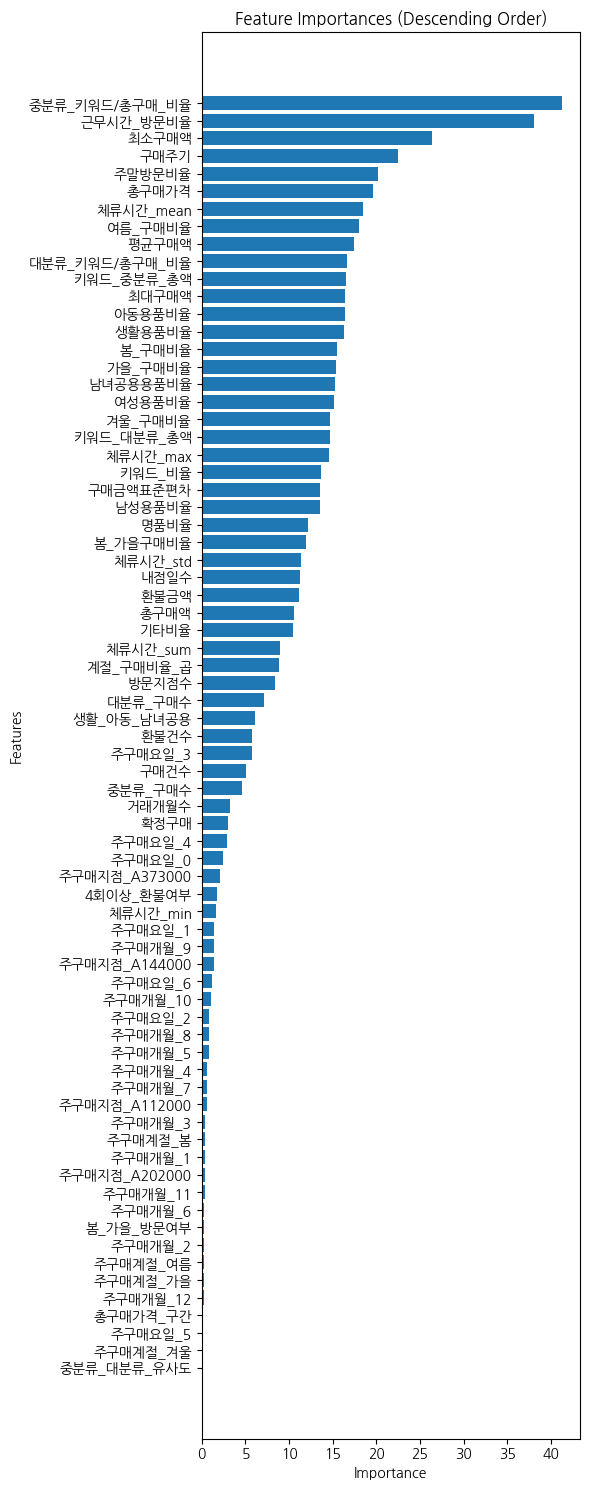

In [63]:
import matplotlib.pyplot as plt

# Assuming you have already calculated the aggregate_importances as shown in the previous code
# Also, assuming you have a DataFrame df containing your dataset

# Sort the feature importances in descending order
sorted_importances = sorted(enumerate(aggregate_importances), key=lambda x: x[1], reverse=True)

# Extract feature names (column names) from your DataFrame
# Replace 'df.columns' with the actual DataFrame containing your data
# Example: feature_names = df.columns.tolist()
feature_names = X_scaled.columns.tolist()

# Extract the sorted importances and corresponding feature names
importance_values = [imp for _, imp in sorted_importances][::-1]  # Reverse the order
sorted_feature_names = [feature_names[idx] for idx, _ in sorted_importances][::-1]  # Reverse the order

# Create a bar plot
plt.figure(figsize=(6, 15))  # Adjust the figsize to make it taller
plt.barh(range(len(importance_values)), importance_values, tick_label=sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances (Descending Order)')

# Show the plot
plt.tight_layout()
plt.show()


In [129]:
pred=soft_bagging_classifier.predict_proba(Y_scaled)

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.143935
1,test_1,0.541229
2,test_2,0.433840
3,test_3,0.774957
4,test_4,0.646364
...,...,...
12220,test_12220,0.807208
12221,test_12221,0.315057
12222,test_12222,0.151697
12223,test_12223,0.210773


In [130]:
submit.to_csv("정재연19차.csv",index=False)

In [119]:
import catboost
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# CatBoost 모델 초기화
model_cat = catboost.CatBoostClassifier(eval_metric='AUC')

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'depth': randint(1, 5),
    'learning_rate': loguniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_cat,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=3,
    n_iter=10,
    random_state=42
)

# 무작위 탐색 수행
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)


0:	total: 13ms	remaining: 3.73s
1:	total: 30.4ms	remaining: 4.35s
2:	total: 80.8ms	remaining: 7.67s
3:	total: 98.3ms	remaining: 6.98s
4:	total: 109ms	remaining: 6.18s
5:	total: 119ms	remaining: 5.59s
6:	total: 128ms	remaining: 5.16s
7:	total: 136ms	remaining: 4.78s
8:	total: 146ms	remaining: 4.53s
9:	total: 155ms	remaining: 4.32s
10:	total: 194ms	remaining: 4.88s
11:	total: 212ms	remaining: 4.87s
12:	total: 261ms	remaining: 5.53s
13:	total: 271ms	remaining: 5.3s
14:	total: 310ms	remaining: 5.65s
15:	total: 328ms	remaining: 5.57s
16:	total: 357ms	remaining: 5.7s
17:	total: 375ms	remaining: 5.63s
18:	total: 386ms	remaining: 5.47s
19:	total: 398ms	remaining: 5.33s
20:	total: 406ms	remaining: 5.16s
21:	total: 415ms	remaining: 5.01s
22:	total: 424ms	remaining: 4.88s
23:	total: 453ms	remaining: 4.98s
24:	total: 473ms	remaining: 4.98s
25:	total: 492ms	remaining: 4.95s
26:	total: 510ms	remaining: 4.93s
27:	total: 525ms	remaining: 4.87s
28:	total: 537ms	remaining: 4.8s
29:	total: 551ms	remainin

252:	total: 4.89s	remaining: 676ms
253:	total: 4.9s	remaining: 656ms
254:	total: 4.92s	remaining: 637ms
255:	total: 4.93s	remaining: 616ms
256:	total: 4.94s	remaining: 596ms
257:	total: 4.95s	remaining: 575ms
258:	total: 4.96s	remaining: 555ms
259:	total: 4.97s	remaining: 535ms
260:	total: 4.98s	remaining: 515ms
261:	total: 5.02s	remaining: 498ms
262:	total: 5.04s	remaining: 479ms
263:	total: 5.05s	remaining: 460ms
264:	total: 5.09s	remaining: 441ms
265:	total: 5.1s	remaining: 422ms
266:	total: 5.11s	remaining: 402ms
267:	total: 5.12s	remaining: 382ms
268:	total: 5.13s	remaining: 362ms
269:	total: 5.15s	remaining: 344ms
270:	total: 5.18s	remaining: 325ms
271:	total: 5.2s	remaining: 306ms
272:	total: 5.24s	remaining: 288ms
273:	total: 5.25s	remaining: 268ms
274:	total: 5.26s	remaining: 249ms
275:	total: 5.27s	remaining: 229ms
276:	total: 5.28s	remaining: 210ms
277:	total: 5.3s	remaining: 191ms
278:	total: 5.34s	remaining: 172ms
279:	total: 5.36s	remaining: 153ms
280:	total: 5.38s	remain

205:	total: 3.58s	remaining: 1.43s
206:	total: 3.6s	remaining: 1.41s
207:	total: 3.6s	remaining: 1.39s
208:	total: 3.61s	remaining: 1.36s
209:	total: 3.62s	remaining: 1.34s
210:	total: 3.63s	remaining: 1.32s
211:	total: 3.65s	remaining: 1.31s
212:	total: 3.7s	remaining: 1.3s
213:	total: 3.72s	remaining: 1.28s
214:	total: 3.74s	remaining: 1.27s
215:	total: 3.75s	remaining: 1.25s
216:	total: 3.77s	remaining: 1.23s
217:	total: 3.77s	remaining: 1.21s
218:	total: 3.78s	remaining: 1.19s
219:	total: 3.79s	remaining: 1.17s
220:	total: 3.8s	remaining: 1.15s
221:	total: 3.83s	remaining: 1.14s
222:	total: 3.85s	remaining: 1.12s
223:	total: 3.87s	remaining: 1.11s
224:	total: 3.89s	remaining: 1.09s
225:	total: 3.91s	remaining: 1.07s
226:	total: 3.93s	remaining: 1.06s
227:	total: 3.94s	remaining: 1.04s
228:	total: 3.95s	remaining: 1.02s
229:	total: 3.96s	remaining: 998ms
230:	total: 3.97s	remaining: 979ms
231:	total: 3.98s	remaining: 960ms
232:	total: 3.98s	remaining: 941ms
233:	total: 4.01s	remaini

157:	total: 2.91s	remaining: 2.4s
158:	total: 2.93s	remaining: 2.38s
159:	total: 2.95s	remaining: 2.36s
160:	total: 2.96s	remaining: 2.33s
161:	total: 2.97s	remaining: 2.31s
162:	total: 2.98s	remaining: 2.28s
163:	total: 2.99s	remaining: 2.26s
164:	total: 3s	remaining: 2.24s
165:	total: 3.01s	remaining: 2.21s
166:	total: 3.02s	remaining: 2.19s
167:	total: 3.04s	remaining: 2.17s
168:	total: 3.09s	remaining: 2.17s
169:	total: 3.11s	remaining: 2.16s
170:	total: 3.12s	remaining: 2.13s
171:	total: 3.13s	remaining: 2.11s
172:	total: 3.14s	remaining: 2.09s
173:	total: 3.15s	remaining: 2.06s
174:	total: 3.15s	remaining: 2.04s
175:	total: 3.16s	remaining: 2.01s
176:	total: 3.18s	remaining: 1.99s
177:	total: 3.23s	remaining: 2s
178:	total: 3.25s	remaining: 1.98s
179:	total: 3.26s	remaining: 1.95s
180:	total: 3.27s	remaining: 1.93s
181:	total: 3.28s	remaining: 1.91s
182:	total: 3.29s	remaining: 1.89s
183:	total: 3.3s	remaining: 1.86s
184:	total: 3.31s	remaining: 1.84s
185:	total: 3.32s	remaining:

117:	total: 1.1s	remaining: 521ms
118:	total: 1.1s	remaining: 509ms
119:	total: 1.1s	remaining: 497ms
120:	total: 1.11s	remaining: 487ms
121:	total: 1.12s	remaining: 476ms
122:	total: 1.12s	remaining: 465ms
123:	total: 1.13s	remaining: 455ms
124:	total: 1.14s	remaining: 445ms
125:	total: 1.15s	remaining: 436ms
126:	total: 1.15s	remaining: 427ms
127:	total: 1.19s	remaining: 429ms
128:	total: 1.2s	remaining: 420ms
129:	total: 1.21s	remaining: 410ms
130:	total: 1.22s	remaining: 400ms
131:	total: 1.23s	remaining: 391ms
132:	total: 1.23s	remaining: 380ms
133:	total: 1.24s	remaining: 370ms
134:	total: 1.25s	remaining: 360ms
135:	total: 1.25s	remaining: 350ms
136:	total: 1.26s	remaining: 340ms
137:	total: 1.26s	remaining: 329ms
138:	total: 1.26s	remaining: 319ms
139:	total: 1.27s	remaining: 309ms
140:	total: 1.27s	remaining: 299ms
141:	total: 1.29s	remaining: 290ms
142:	total: 1.29s	remaining: 281ms
143:	total: 1.3s	remaining: 272ms
144:	total: 1.33s	remaining: 266ms
145:	total: 1.34s	remaini

26:	total: 204ms	remaining: 1.11s
27:	total: 209ms	remaining: 1.09s
28:	total: 213ms	remaining: 1.06s
29:	total: 260ms	remaining: 1.25s
30:	total: 268ms	remaining: 1.24s
31:	total: 277ms	remaining: 1.23s
32:	total: 285ms	remaining: 1.22s
33:	total: 322ms	remaining: 1.32s
34:	total: 333ms	remaining: 1.32s
35:	total: 339ms	remaining: 1.3s
36:	total: 344ms	remaining: 1.27s
37:	total: 349ms	remaining: 1.25s
38:	total: 354ms	remaining: 1.23s
39:	total: 360ms	remaining: 1.21s
40:	total: 366ms	remaining: 1.19s
41:	total: 371ms	remaining: 1.17s
42:	total: 375ms	remaining: 1.14s
43:	total: 379ms	remaining: 1.12s
44:	total: 385ms	remaining: 1.1s
45:	total: 390ms	remaining: 1.08s
46:	total: 394ms	remaining: 1.06s
47:	total: 408ms	remaining: 1.07s
48:	total: 417ms	remaining: 1.06s
49:	total: 426ms	remaining: 1.05s
50:	total: 434ms	remaining: 1.05s
51:	total: 457ms	remaining: 1.07s
52:	total: 465ms	remaining: 1.06s
53:	total: 474ms	remaining: 1.05s
54:	total: 483ms	remaining: 1.04s
55:	total: 495ms

93:	total: 1.82s	remaining: 2.64s
94:	total: 1.84s	remaining: 2.62s
95:	total: 1.86s	remaining: 2.6s
96:	total: 1.88s	remaining: 2.58s
97:	total: 1.91s	remaining: 2.57s
98:	total: 1.91s	remaining: 2.53s
99:	total: 1.92s	remaining: 2.5s
100:	total: 1.93s	remaining: 2.46s
101:	total: 1.94s	remaining: 2.43s
102:	total: 1.94s	remaining: 2.4s
103:	total: 1.96s	remaining: 2.38s
104:	total: 1.98s	remaining: 2.36s
105:	total: 2s	remaining: 2.34s
106:	total: 2.02s	remaining: 2.32s
107:	total: 2.04s	remaining: 2.31s
108:	total: 2.06s	remaining: 2.28s
109:	total: 2.06s	remaining: 2.25s
110:	total: 2.09s	remaining: 2.24s
111:	total: 2.11s	remaining: 2.22s
112:	total: 2.16s	remaining: 2.23s
113:	total: 2.17s	remaining: 2.21s
114:	total: 2.18s	remaining: 2.18s
115:	total: 2.19s	remaining: 2.15s
116:	total: 2.2s	remaining: 2.13s
117:	total: 2.23s	remaining: 2.11s
118:	total: 2.25s	remaining: 2.1s
119:	total: 2.28s	remaining: 2.09s
120:	total: 2.3s	remaining: 2.07s
121:	total: 2.31s	remaining: 2.04s
1

109:	total: 2.01s	remaining: 2.19s
110:	total: 2.07s	remaining: 2.22s
111:	total: 2.09s	remaining: 2.2s
112:	total: 2.1s	remaining: 2.18s
113:	total: 2.11s	remaining: 2.15s
114:	total: 2.12s	remaining: 2.12s
115:	total: 2.13s	remaining: 2.1s
116:	total: 2.15s	remaining: 2.08s
117:	total: 2.2s	remaining: 2.09s
118:	total: 2.22s	remaining: 2.07s
119:	total: 2.23s	remaining: 2.04s
120:	total: 2.24s	remaining: 2.02s
121:	total: 2.25s	remaining: 1.99s
122:	total: 2.27s	remaining: 1.98s
123:	total: 2.3s	remaining: 1.97s
124:	total: 2.32s	remaining: 1.95s
125:	total: 2.33s	remaining: 1.93s
126:	total: 2.35s	remaining: 1.91s
127:	total: 2.37s	remaining: 1.89s
128:	total: 2.38s	remaining: 1.86s
129:	total: 2.39s	remaining: 1.84s
130:	total: 2.4s	remaining: 1.81s
131:	total: 2.41s	remaining: 1.79s
132:	total: 2.42s	remaining: 1.76s
133:	total: 2.43s	remaining: 1.74s
134:	total: 2.45s	remaining: 1.73s
135:	total: 2.52s	remaining: 1.74s
136:	total: 2.54s	remaining: 1.72s
137:	total: 2.55s	remainin

128:	total: 2.53s	remaining: 1.98s
129:	total: 2.55s	remaining: 1.96s
130:	total: 2.57s	remaining: 1.94s
131:	total: 2.58s	remaining: 1.92s
132:	total: 2.59s	remaining: 1.89s
133:	total: 2.6s	remaining: 1.86s
134:	total: 2.6s	remaining: 1.83s
135:	total: 2.62s	remaining: 1.81s
136:	total: 2.64s	remaining: 1.79s
137:	total: 2.66s	remaining: 1.77s
138:	total: 2.68s	remaining: 1.76s
139:	total: 2.7s	remaining: 1.74s
140:	total: 2.71s	remaining: 1.71s
141:	total: 2.72s	remaining: 1.68s
142:	total: 2.72s	remaining: 1.66s
143:	total: 2.73s	remaining: 1.63s
144:	total: 2.73s	remaining: 1.6s
145:	total: 2.74s	remaining: 1.58s
146:	total: 2.75s	remaining: 1.55s
147:	total: 2.76s	remaining: 1.53s
148:	total: 2.77s	remaining: 1.51s
149:	total: 2.79s	remaining: 1.49s
150:	total: 2.81s	remaining: 1.47s
151:	total: 2.83s	remaining: 1.45s
152:	total: 2.84s	remaining: 1.43s
153:	total: 2.85s	remaining: 1.41s
154:	total: 2.86s	remaining: 1.38s
155:	total: 2.87s	remaining: 1.36s
156:	total: 2.88s	remain

150:	total: 1.98s	remaining: 1.39s
151:	total: 1.98s	remaining: 1.37s
152:	total: 1.99s	remaining: 1.35s
153:	total: 1.99s	remaining: 1.33s
154:	total: 2s	remaining: 1.31s
155:	total: 2s	remaining: 1.3s
156:	total: 2.01s	remaining: 1.28s
157:	total: 2.03s	remaining: 1.27s
158:	total: 2.04s	remaining: 1.26s
159:	total: 2.06s	remaining: 1.25s
160:	total: 2.11s	remaining: 1.26s
161:	total: 2.12s	remaining: 1.24s
162:	total: 2.13s	remaining: 1.23s
163:	total: 2.14s	remaining: 1.22s
164:	total: 2.15s	remaining: 1.2s
165:	total: 2.16s	remaining: 1.18s
166:	total: 2.16s	remaining: 1.17s
167:	total: 2.17s	remaining: 1.15s
168:	total: 2.18s	remaining: 1.14s
169:	total: 2.19s	remaining: 1.12s
170:	total: 2.2s	remaining: 1.11s
171:	total: 2.21s	remaining: 1.09s
172:	total: 2.27s	remaining: 1.1s
173:	total: 2.28s	remaining: 1.09s
174:	total: 2.29s	remaining: 1.07s
175:	total: 2.3s	remaining: 1.06s
176:	total: 2.31s	remaining: 1.05s
177:	total: 2.32s	remaining: 1.03s
178:	total: 2.33s	remaining: 1.

142:	total: 2.13s	remaining: 1.7s
143:	total: 2.17s	remaining: 1.7s
144:	total: 2.18s	remaining: 1.69s
145:	total: 2.19s	remaining: 1.67s
146:	total: 2.2s	remaining: 1.65s
147:	total: 2.21s	remaining: 1.63s
148:	total: 2.22s	remaining: 1.61s
149:	total: 2.22s	remaining: 1.59s
150:	total: 2.23s	remaining: 1.57s
151:	total: 2.24s	remaining: 1.54s
152:	total: 2.25s	remaining: 1.53s
153:	total: 2.26s	remaining: 1.51s
154:	total: 2.27s	remaining: 1.49s
155:	total: 2.29s	remaining: 1.48s
156:	total: 2.3s	remaining: 1.46s
157:	total: 2.31s	remaining: 1.45s
158:	total: 2.32s	remaining: 1.43s
159:	total: 2.33s	remaining: 1.41s
160:	total: 2.34s	remaining: 1.4s
161:	total: 2.35s	remaining: 1.38s
162:	total: 2.35s	remaining: 1.36s
163:	total: 2.37s	remaining: 1.34s
164:	total: 2.38s	remaining: 1.33s
165:	total: 2.39s	remaining: 1.31s
166:	total: 2.42s	remaining: 1.3s
167:	total: 2.43s	remaining: 1.29s
168:	total: 2.44s	remaining: 1.27s
169:	total: 2.45s	remaining: 1.25s
170:	total: 2.46s	remainin

129:	total: 1.71s	remaining: 1.67s
130:	total: 1.73s	remaining: 1.66s
131:	total: 1.74s	remaining: 1.64s
132:	total: 1.74s	remaining: 1.62s
133:	total: 1.75s	remaining: 1.61s
134:	total: 1.76s	remaining: 1.59s
135:	total: 1.81s	remaining: 1.61s
136:	total: 1.82s	remaining: 1.6s
137:	total: 1.84s	remaining: 1.58s
138:	total: 1.86s	remaining: 1.58s
139:	total: 1.88s	remaining: 1.57s
140:	total: 1.88s	remaining: 1.55s
141:	total: 1.89s	remaining: 1.53s
142:	total: 1.9s	remaining: 1.51s
143:	total: 1.9s	remaining: 1.49s
144:	total: 1.93s	remaining: 1.49s
145:	total: 1.94s	remaining: 1.48s
146:	total: 1.95s	remaining: 1.46s
147:	total: 1.97s	remaining: 1.45s
148:	total: 1.98s	remaining: 1.43s
149:	total: 1.99s	remaining: 1.42s
150:	total: 2.01s	remaining: 1.41s
151:	total: 2.02s	remaining: 1.39s
152:	total: 2.02s	remaining: 1.38s
153:	total: 2.04s	remaining: 1.36s
154:	total: 2.05s	remaining: 1.35s
155:	total: 2.09s	remaining: 1.35s
156:	total: 2.1s	remaining: 1.34s
157:	total: 2.12s	remain

120:	total: 1.99s	remaining: 2.29s
121:	total: 2.01s	remaining: 2.27s
122:	total: 2.03s	remaining: 2.26s
123:	total: 2.06s	remaining: 2.26s
124:	total: 2.06s	remaining: 2.23s
125:	total: 2.07s	remaining: 2.2s
126:	total: 2.08s	remaining: 2.17s
127:	total: 2.08s	remaining: 2.15s
128:	total: 2.09s	remaining: 2.12s
129:	total: 2.09s	remaining: 2.09s
130:	total: 2.1s	remaining: 2.07s
131:	total: 2.13s	remaining: 2.07s
132:	total: 2.15s	remaining: 2.05s
133:	total: 2.17s	remaining: 2.04s
134:	total: 2.18s	remaining: 2.02s
135:	total: 2.23s	remaining: 2.04s
136:	total: 2.25s	remaining: 2.02s
137:	total: 2.27s	remaining: 2.01s
138:	total: 2.29s	remaining: 1.99s
139:	total: 2.3s	remaining: 1.97s
140:	total: 2.31s	remaining: 1.95s
141:	total: 2.32s	remaining: 1.93s
142:	total: 2.33s	remaining: 1.91s
143:	total: 2.35s	remaining: 1.89s
144:	total: 2.37s	remaining: 1.88s
145:	total: 2.38s	remaining: 1.86s
146:	total: 2.43s	remaining: 1.87s
147:	total: 2.46s	remaining: 1.86s
148:	total: 2.47s	remai

104:	total: 1.71s	remaining: 2.52s
105:	total: 1.75s	remaining: 2.54s
106:	total: 1.76s	remaining: 2.52s
107:	total: 1.77s	remaining: 2.49s
108:	total: 1.77s	remaining: 2.46s
109:	total: 1.78s	remaining: 2.43s
110:	total: 1.82s	remaining: 2.44s
111:	total: 1.83s	remaining: 2.42s
112:	total: 1.88s	remaining: 2.45s
113:	total: 1.89s	remaining: 2.42s
114:	total: 1.9s	remaining: 2.4s
115:	total: 1.92s	remaining: 2.38s
116:	total: 1.92s	remaining: 2.35s
117:	total: 1.93s	remaining: 2.33s
118:	total: 1.95s	remaining: 2.31s
119:	total: 1.96s	remaining: 2.29s
120:	total: 2s	remaining: 2.3s
121:	total: 2.02s	remaining: 2.28s
122:	total: 2.03s	remaining: 2.26s
123:	total: 2.05s	remaining: 2.24s
124:	total: 2.06s	remaining: 2.23s
125:	total: 2.08s	remaining: 2.21s
126:	total: 2.09s	remaining: 2.19s
127:	total: 2.14s	remaining: 2.21s
128:	total: 2.15s	remaining: 2.19s
129:	total: 2.19s	remaining: 2.19s
130:	total: 2.21s	remaining: 2.17s
131:	total: 2.21s	remaining: 2.15s
132:	total: 2.22s	remainin

82:	total: 1.6s	remaining: 3.41s
83:	total: 1.61s	remaining: 3.38s
84:	total: 1.62s	remaining: 3.35s
85:	total: 1.63s	remaining: 3.3s
86:	total: 1.66s	remaining: 3.31s
87:	total: 1.68s	remaining: 3.28s
88:	total: 1.71s	remaining: 3.29s
89:	total: 1.73s	remaining: 3.27s
90:	total: 1.74s	remaining: 3.23s
91:	total: 1.74s	remaining: 3.19s
92:	total: 1.75s	remaining: 3.14s
93:	total: 1.79s	remaining: 3.17s
94:	total: 1.81s	remaining: 3.15s
95:	total: 1.83s	remaining: 3.12s
96:	total: 1.83s	remaining: 3.08s
97:	total: 1.84s	remaining: 3.04s
98:	total: 1.85s	remaining: 3.01s
99:	total: 1.86s	remaining: 2.98s
100:	total: 1.91s	remaining: 3.01s
101:	total: 1.93s	remaining: 2.98s
102:	total: 1.94s	remaining: 2.96s
103:	total: 1.95s	remaining: 2.93s
104:	total: 1.96s	remaining: 2.89s
105:	total: 1.97s	remaining: 2.86s
106:	total: 1.98s	remaining: 2.84s
107:	total: 2s	remaining: 2.82s
108:	total: 2.02s	remaining: 2.8s
109:	total: 2.04s	remaining: 2.78s
110:	total: 2.05s	remaining: 2.75s
111:	tota

60:	total: 2.84s	remaining: 5.91s
61:	total: 2.9s	remaining: 5.88s
62:	total: 2.91s	remaining: 5.78s
63:	total: 2.93s	remaining: 5.67s
64:	total: 2.99s	remaining: 5.67s
65:	total: 3.06s	remaining: 5.65s
66:	total: 3.08s	remaining: 5.57s
67:	total: 3.11s	remaining: 5.48s
68:	total: 3.14s	remaining: 5.41s
69:	total: 3.21s	remaining: 5.4s
70:	total: 3.23s	remaining: 5.32s
71:	total: 3.25s	remaining: 5.24s
72:	total: 3.29s	remaining: 5.18s
73:	total: 3.36s	remaining: 5.17s
74:	total: 3.39s	remaining: 5.1s
75:	total: 3.41s	remaining: 5.03s
76:	total: 3.52s	remaining: 5.08s
77:	total: 3.57s	remaining: 5.03s
78:	total: 3.59s	remaining: 4.95s
79:	total: 3.66s	remaining: 4.94s
80:	total: 3.7s	remaining: 4.89s
81:	total: 3.73s	remaining: 4.82s
82:	total: 3.75s	remaining: 4.74s
83:	total: 3.84s	remaining: 4.76s
84:	total: 3.87s	remaining: 4.69s
85:	total: 3.94s	remaining: 4.68s
86:	total: 3.97s	remaining: 4.61s
87:	total: 4.06s	remaining: 4.61s
88:	total: 4.11s	remaining: 4.57s
89:	total: 4.14s	r

113:	total: 5.38s	remaining: 3.49s
114:	total: 5.43s	remaining: 3.45s
115:	total: 5.52s	remaining: 3.43s
116:	total: 5.55s	remaining: 3.37s
117:	total: 5.57s	remaining: 3.3s
118:	total: 5.63s	remaining: 3.27s
119:	total: 5.68s	remaining: 3.22s
120:	total: 5.7s	remaining: 3.15s
121:	total: 5.72s	remaining: 3.09s
122:	total: 5.78s	remaining: 3.06s
123:	total: 5.82s	remaining: 3s
124:	total: 5.85s	remaining: 2.95s
125:	total: 5.87s	remaining: 2.89s
126:	total: 5.96s	remaining: 2.86s
127:	total: 5.99s	remaining: 2.81s
128:	total: 6.01s	remaining: 2.75s
129:	total: 6.12s	remaining: 2.73s
130:	total: 6.14s	remaining: 2.67s
131:	total: 6.16s	remaining: 2.62s
132:	total: 6.21s	remaining: 2.57s
133:	total: 6.25s	remaining: 2.52s
134:	total: 6.28s	remaining: 2.46s
135:	total: 6.35s	remaining: 2.43s
136:	total: 6.38s	remaining: 2.37s
137:	total: 6.4s	remaining: 2.32s
138:	total: 6.43s	remaining: 2.27s
139:	total: 6.51s	remaining: 2.23s
140:	total: 6.54s	remaining: 2.18s
141:	total: 6.56s	remainin

167:	total: 8.01s	remaining: 953ms
168:	total: 8.04s	remaining: 904ms
169:	total: 8.08s	remaining: 856ms
170:	total: 8.16s	remaining: 811ms
171:	total: 8.19s	remaining: 761ms
172:	total: 8.21s	remaining: 712ms
173:	total: 8.29s	remaining: 667ms
174:	total: 8.32s	remaining: 618ms
175:	total: 8.34s	remaining: 569ms
176:	total: 8.37s	remaining: 520ms
177:	total: 8.43s	remaining: 474ms
178:	total: 8.52s	remaining: 429ms
179:	total: 8.58s	remaining: 382ms
180:	total: 8.68s	remaining: 336ms
181:	total: 8.79s	remaining: 290ms
182:	total: 8.83s	remaining: 241ms
183:	total: 8.91s	remaining: 194ms
184:	total: 8.94s	remaining: 145ms
185:	total: 8.97s	remaining: 96.4ms
186:	total: 9.04s	remaining: 48.3ms
187:	total: 9.06s	remaining: 0us
0:	total: 5.75ms	remaining: 1.64s
1:	total: 11.6ms	remaining: 1.65s
2:	total: 16ms	remaining: 1.52s
3:	total: 21.3ms	remaining: 1.51s
4:	total: 25.7ms	remaining: 1.45s
5:	total: 31.9ms	remaining: 1.5s
6:	total: 50ms	remaining: 2s
7:	total: 58.4ms	remaining: 2.04s
8

232:	total: 2.4s	remaining: 556ms
233:	total: 2.41s	remaining: 546ms
234:	total: 2.41s	remaining: 534ms
235:	total: 2.42s	remaining: 523ms
236:	total: 2.43s	remaining: 512ms
237:	total: 2.43s	remaining: 501ms
238:	total: 2.45s	remaining: 491ms
239:	total: 2.46s	remaining: 481ms
240:	total: 2.46s	remaining: 471ms
241:	total: 2.51s	remaining: 467ms
242:	total: 2.52s	remaining: 456ms
243:	total: 2.52s	remaining: 445ms
244:	total: 2.53s	remaining: 433ms
245:	total: 2.54s	remaining: 423ms
246:	total: 2.54s	remaining: 412ms
247:	total: 2.55s	remaining: 401ms
248:	total: 2.57s	remaining: 392ms
249:	total: 2.58s	remaining: 382ms
250:	total: 2.59s	remaining: 371ms
251:	total: 2.64s	remaining: 367ms
252:	total: 2.65s	remaining: 356ms
253:	total: 2.66s	remaining: 345ms
254:	total: 2.66s	remaining: 334ms
255:	total: 2.67s	remaining: 323ms
256:	total: 2.67s	remaining: 312ms
257:	total: 2.67s	remaining: 301ms
258:	total: 2.68s	remaining: 290ms
259:	total: 2.69s	remaining: 279ms
260:	total: 2.69s	rem

206:	total: 2.13s	remaining: 823ms
207:	total: 2.14s	remaining: 812ms
208:	total: 2.15s	remaining: 801ms
209:	total: 2.15s	remaining: 789ms
210:	total: 2.16s	remaining: 777ms
211:	total: 2.16s	remaining: 765ms
212:	total: 2.17s	remaining: 753ms
213:	total: 2.17s	remaining: 742ms
214:	total: 2.18s	remaining: 730ms
215:	total: 2.19s	remaining: 718ms
216:	total: 2.19s	remaining: 707ms
217:	total: 2.21s	remaining: 700ms
218:	total: 2.22s	remaining: 689ms
219:	total: 2.23s	remaining: 679ms
220:	total: 2.24s	remaining: 668ms
221:	total: 2.31s	remaining: 677ms
222:	total: 2.32s	remaining: 665ms
223:	total: 2.32s	remaining: 653ms
224:	total: 2.33s	remaining: 641ms
225:	total: 2.33s	remaining: 629ms
226:	total: 2.33s	remaining: 617ms
227:	total: 2.34s	remaining: 605ms
228:	total: 2.35s	remaining: 594ms
229:	total: 2.35s	remaining: 583ms
230:	total: 2.36s	remaining: 571ms
231:	total: 2.36s	remaining: 560ms
232:	total: 2.37s	remaining: 548ms
233:	total: 2.37s	remaining: 537ms
234:	total: 2.38s	re

173:	total: 1.74s	remaining: 1.13s
174:	total: 1.75s	remaining: 1.12s
175:	total: 1.76s	remaining: 1.11s
176:	total: 1.77s	remaining: 1.1s
177:	total: 1.83s	remaining: 1.12s
178:	total: 1.84s	remaining: 1.11s
179:	total: 1.84s	remaining: 1.09s
180:	total: 1.85s	remaining: 1.08s
181:	total: 1.85s	remaining: 1.07s
182:	total: 1.85s	remaining: 1.05s
183:	total: 1.86s	remaining: 1.04s
184:	total: 1.86s	remaining: 1.03s
185:	total: 1.87s	remaining: 1.01s
186:	total: 1.88s	remaining: 1s
187:	total: 1.88s	remaining: 991ms
188:	total: 1.89s	remaining: 980ms
189:	total: 1.9s	remaining: 969ms
190:	total: 1.91s	remaining: 959ms
191:	total: 1.92s	remaining: 950ms
192:	total: 1.95s	remaining: 950ms
193:	total: 1.96s	remaining: 939ms
194:	total: 1.97s	remaining: 929ms
195:	total: 1.98s	remaining: 918ms
196:	total: 2.04s	remaining: 930ms
197:	total: 2.04s	remaining: 919ms
198:	total: 2.05s	remaining: 907ms
199:	total: 2.06s	remaining: 895ms
200:	total: 2.06s	remaining: 883ms
201:	total: 2.07s	remaini

127:	total: 5.69s	remaining: 7.16s
128:	total: 5.72s	remaining: 7.09s
129:	total: 5.74s	remaining: 7.01s
130:	total: 5.79s	remaining: 6.98s
131:	total: 5.86s	remaining: 6.97s
132:	total: 5.88s	remaining: 6.9s
133:	total: 5.94s	remaining: 6.87s
134:	total: 6s	remaining: 6.85s
135:	total: 6.02s	remaining: 6.78s
136:	total: 6.04s	remaining: 6.71s
137:	total: 6.06s	remaining: 6.63s
138:	total: 6.09s	remaining: 6.57s
139:	total: 6.14s	remaining: 6.54s
140:	total: 6.23s	remaining: 6.54s
141:	total: 6.25s	remaining: 6.47s
142:	total: 6.27s	remaining: 6.4s
143:	total: 6.34s	remaining: 6.38s
144:	total: 6.38s	remaining: 6.33s
145:	total: 6.4s	remaining: 6.27s
146:	total: 6.45s	remaining: 6.23s
147:	total: 6.5s	remaining: 6.19s
148:	total: 6.52s	remaining: 6.13s
149:	total: 6.54s	remaining: 6.06s
150:	total: 6.59s	remaining: 6.03s
151:	total: 6.65s	remaining: 6s
152:	total: 6.67s	remaining: 5.93s
153:	total: 6.69s	remaining: 5.87s
154:	total: 6.73s	remaining: 5.82s
155:	total: 6.8s	remaining: 5.

81:	total: 3.6s	remaining: 9.08s
82:	total: 3.68s	remaining: 9.13s
83:	total: 3.7s	remaining: 9.03s
84:	total: 3.71s	remaining: 8.92s
85:	total: 3.81s	remaining: 9s
86:	total: 3.85s	remaining: 8.93s
87:	total: 3.86s	remaining: 8.83s
88:	total: 3.91s	remaining: 8.79s
89:	total: 3.99s	remaining: 8.82s
90:	total: 4.01s	remaining: 8.73s
91:	total: 4.03s	remaining: 8.63s
92:	total: 4.05s	remaining: 8.53s
93:	total: 4.15s	remaining: 8.61s
94:	total: 4.19s	remaining: 8.55s
95:	total: 4.21s	remaining: 8.46s
96:	total: 4.22s	remaining: 8.36s
97:	total: 4.25s	remaining: 8.27s
98:	total: 4.32s	remaining: 8.29s
99:	total: 4.35s	remaining: 8.23s
100:	total: 4.37s	remaining: 8.14s
101:	total: 4.42s	remaining: 8.11s
102:	total: 4.51s	remaining: 8.14s
103:	total: 4.53s	remaining: 8.06s
104:	total: 4.55s	remaining: 7.97s
105:	total: 4.59s	remaining: 7.92s
106:	total: 4.64s	remaining: 7.89s
107:	total: 4.67s	remaining: 7.82s
108:	total: 4.71s	remaining: 7.78s
109:	total: 4.8s	remaining: 7.82s
110:	total

30:	total: 1.66s	remaining: 13.8s
31:	total: 1.73s	remaining: 13.9s
32:	total: 1.74s	remaining: 13.5s
33:	total: 1.82s	remaining: 13.7s
34:	total: 1.89s	remaining: 13.7s
35:	total: 1.91s	remaining: 13.4s
36:	total: 1.94s	remaining: 13.2s
37:	total: 2.03s	remaining: 13.4s
38:	total: 2.06s	remaining: 13.2s
39:	total: 2.08s	remaining: 13s
40:	total: 2.14s	remaining: 13s
41:	total: 2.23s	remaining: 13.1s
42:	total: 2.26s	remaining: 12.9s
43:	total: 2.38s	remaining: 13.2s
44:	total: 2.41s	remaining: 13s
45:	total: 2.49s	remaining: 13.2s
46:	total: 2.52s	remaining: 13s
47:	total: 2.54s	remaining: 12.7s
48:	total: 2.55s	remaining: 12.5s
49:	total: 2.58s	remaining: 12.3s
50:	total: 2.65s	remaining: 12.3s
51:	total: 2.67s	remaining: 12.2s
52:	total: 2.69s	remaining: 12s
53:	total: 2.71s	remaining: 11.8s
54:	total: 2.83s	remaining: 12s
55:	total: 2.87s	remaining: 11.9s
56:	total: 2.89s	remaining: 11.7s
57:	total: 3s	remaining: 11.9s
58:	total: 3.04s	remaining: 11.8s
59:	total: 3.12s	remaining: 1

270:	total: 12s	remaining: 795ms
271:	total: 12s	remaining: 749ms
272:	total: 12s	remaining: 705ms
273:	total: 12.1s	remaining: 663ms
274:	total: 12.1s	remaining: 618ms
275:	total: 12.2s	remaining: 573ms
276:	total: 12.2s	remaining: 531ms
277:	total: 12.3s	remaining: 486ms
278:	total: 12.3s	remaining: 441ms
279:	total: 12.3s	remaining: 396ms
280:	total: 12.3s	remaining: 351ms
281:	total: 12.4s	remaining: 309ms
282:	total: 12.5s	remaining: 264ms
283:	total: 12.5s	remaining: 220ms
284:	total: 12.5s	remaining: 176ms
285:	total: 12.6s	remaining: 132ms
286:	total: 12.6s	remaining: 88ms
287:	total: 12.7s	remaining: 44.1ms
288:	total: 12.7s	remaining: 0us
0:	total: 15ms	remaining: 3.44s
1:	total: 27.1ms	remaining: 3.09s
2:	total: 37.7ms	remaining: 2.85s
3:	total: 61.8ms	remaining: 3.49s
4:	total: 102ms	remaining: 4.59s
5:	total: 131ms	remaining: 4.88s
6:	total: 144ms	remaining: 4.58s
7:	total: 158ms	remaining: 4.38s
8:	total: 170ms	remaining: 4.18s
9:	total: 182ms	remaining: 4s
10:	total: 196

228:	total: 9.71s	remaining: 42.4ms
229:	total: 9.72s	remaining: 0us
0:	total: 15.1ms	remaining: 3.47s
1:	total: 26.8ms	remaining: 3.06s
2:	total: 38.5ms	remaining: 2.92s
3:	total: 49.2ms	remaining: 2.78s
4:	total: 69.4ms	remaining: 3.12s
5:	total: 110ms	remaining: 4.1s
6:	total: 133ms	remaining: 4.24s
7:	total: 155ms	remaining: 4.29s
8:	total: 170ms	remaining: 4.18s
9:	total: 183ms	remaining: 4.02s
10:	total: 194ms	remaining: 3.86s
11:	total: 245ms	remaining: 4.45s
12:	total: 280ms	remaining: 4.67s
13:	total: 301ms	remaining: 4.64s
14:	total: 316ms	remaining: 4.53s
15:	total: 340ms	remaining: 4.55s
16:	total: 394ms	remaining: 4.93s
17:	total: 418ms	remaining: 4.92s
18:	total: 441ms	remaining: 4.9s
19:	total: 459ms	remaining: 4.82s
20:	total: 506ms	remaining: 5.04s
21:	total: 530ms	remaining: 5.01s
22:	total: 578ms	remaining: 5.2s
23:	total: 590ms	remaining: 5.06s
24:	total: 598ms	remaining: 4.9s
25:	total: 610ms	remaining: 4.79s
26:	total: 658ms	remaining: 4.95s
27:	total: 714ms	remai

9:	total: 244ms	remaining: 5.36s
10:	total: 264ms	remaining: 5.26s
11:	total: 278ms	remaining: 5.05s
12:	total: 303ms	remaining: 5.05s
13:	total: 327ms	remaining: 5.04s
14:	total: 352ms	remaining: 5.05s
15:	total: 388ms	remaining: 5.18s
16:	total: 411ms	remaining: 5.15s
17:	total: 421ms	remaining: 4.96s
18:	total: 447ms	remaining: 4.97s
19:	total: 471ms	remaining: 4.95s
20:	total: 507ms	remaining: 5.05s
21:	total: 534ms	remaining: 5.05s
22:	total: 550ms	remaining: 4.95s
23:	total: 560ms	remaining: 4.8s
24:	total: 571ms	remaining: 4.69s
25:	total: 581ms	remaining: 4.56s
26:	total: 622ms	remaining: 4.67s
27:	total: 673ms	remaining: 4.85s
28:	total: 693ms	remaining: 4.8s
29:	total: 708ms	remaining: 4.72s
30:	total: 723ms	remaining: 4.64s
31:	total: 791ms	remaining: 4.89s
32:	total: 831ms	remaining: 4.96s
33:	total: 848ms	remaining: 4.89s
34:	total: 862ms	remaining: 4.8s
35:	total: 875ms	remaining: 4.72s
36:	total: 901ms	remaining: 4.7s
37:	total: 958ms	remaining: 4.84s
38:	total: 981ms	re

19:	total: 200ms	remaining: 2.45s
20:	total: 205ms	remaining: 2.39s
21:	total: 210ms	remaining: 2.33s
22:	total: 219ms	remaining: 2.31s
23:	total: 228ms	remaining: 2.29s
24:	total: 252ms	remaining: 2.43s
25:	total: 261ms	remaining: 2.41s
26:	total: 269ms	remaining: 2.38s
27:	total: 278ms	remaining: 2.37s
28:	total: 303ms	remaining: 2.48s
29:	total: 310ms	remaining: 2.44s
30:	total: 329ms	remaining: 2.49s
31:	total: 338ms	remaining: 2.47s
32:	total: 345ms	remaining: 2.43s
33:	total: 351ms	remaining: 2.4s
34:	total: 358ms	remaining: 2.36s
35:	total: 363ms	remaining: 2.32s
36:	total: 368ms	remaining: 2.28s
37:	total: 372ms	remaining: 2.23s
38:	total: 377ms	remaining: 2.19s
39:	total: 380ms	remaining: 2.15s
40:	total: 387ms	remaining: 2.12s
41:	total: 390ms	remaining: 2.08s
42:	total: 417ms	remaining: 2.16s
43:	total: 426ms	remaining: 2.15s
44:	total: 435ms	remaining: 2.13s
45:	total: 444ms	remaining: 2.12s
46:	total: 450ms	remaining: 2.1s
47:	total: 462ms	remaining: 2.1s
48:	total: 467ms	

0:	total: 4.4ms	remaining: 1.17s
1:	total: 9.66ms	remaining: 1.27s
2:	total: 13.6ms	remaining: 1.19s
3:	total: 17.8ms	remaining: 1.17s
4:	total: 22.1ms	remaining: 1.15s
5:	total: 25.8ms	remaining: 1.12s
6:	total: 29.1ms	remaining: 1.08s
7:	total: 32.7ms	remaining: 1.05s
8:	total: 36.3ms	remaining: 1.04s
9:	total: 40.4ms	remaining: 1.03s
10:	total: 46.1ms	remaining: 1.07s
11:	total: 55.1ms	remaining: 1.17s
12:	total: 63.6ms	remaining: 1.24s
13:	total: 71.9ms	remaining: 1.29s
14:	total: 112ms	remaining: 1.88s
15:	total: 121ms	remaining: 1.89s
16:	total: 129ms	remaining: 1.9s
17:	total: 138ms	remaining: 1.9s
18:	total: 145ms	remaining: 1.89s
19:	total: 151ms	remaining: 1.86s
20:	total: 158ms	remaining: 1.85s
21:	total: 164ms	remaining: 1.82s
22:	total: 170ms	remaining: 1.79s
23:	total: 174ms	remaining: 1.75s
24:	total: 179ms	remaining: 1.73s
25:	total: 185ms	remaining: 1.71s
26:	total: 189ms	remaining: 1.68s
27:	total: 194ms	remaining: 1.65s
28:	total: 199ms	remaining: 1.63s
29:	total: 25

251:	total: 2.55s	remaining: 142ms
252:	total: 2.56s	remaining: 131ms
253:	total: 2.56s	remaining: 121ms
254:	total: 2.57s	remaining: 111ms
255:	total: 2.57s	remaining: 100ms
256:	total: 2.58s	remaining: 90.2ms
257:	total: 2.58s	remaining: 80.1ms
258:	total: 2.59s	remaining: 70.1ms
259:	total: 2.6s	remaining: 60.1ms
260:	total: 2.61s	remaining: 50ms
261:	total: 2.63s	remaining: 40.2ms
262:	total: 2.64s	remaining: 30.1ms
263:	total: 2.65s	remaining: 20.1ms
264:	total: 2.66s	remaining: 10ms
265:	total: 2.67s	remaining: 0us
0:	total: 5.27ms	remaining: 1.4s
1:	total: 10.8ms	remaining: 1.42s
2:	total: 15.3ms	remaining: 1.34s
3:	total: 20.7ms	remaining: 1.36s
4:	total: 26.3ms	remaining: 1.37s
5:	total: 31.2ms	remaining: 1.35s
6:	total: 36.4ms	remaining: 1.35s
7:	total: 43.9ms	remaining: 1.42s
8:	total: 68.3ms	remaining: 1.95s
9:	total: 76.6ms	remaining: 1.96s
10:	total: 84.8ms	remaining: 1.97s
11:	total: 141ms	remaining: 2.99s
12:	total: 147ms	remaining: 2.86s
13:	total: 154ms	remaining: 2.7

229:	total: 2.12s	remaining: 332ms
230:	total: 2.13s	remaining: 322ms
231:	total: 2.14s	remaining: 313ms
232:	total: 2.15s	remaining: 304ms
233:	total: 2.17s	remaining: 297ms
234:	total: 2.18s	remaining: 288ms
235:	total: 2.19s	remaining: 278ms
236:	total: 2.2s	remaining: 269ms
237:	total: 2.21s	remaining: 260ms
238:	total: 2.21s	remaining: 250ms
239:	total: 2.22s	remaining: 241ms
240:	total: 2.23s	remaining: 231ms
241:	total: 2.23s	remaining: 222ms
242:	total: 2.24s	remaining: 212ms
243:	total: 2.24s	remaining: 202ms
244:	total: 2.25s	remaining: 193ms
245:	total: 2.26s	remaining: 183ms
246:	total: 2.26s	remaining: 174ms
247:	total: 2.27s	remaining: 165ms
248:	total: 2.28s	remaining: 156ms
249:	total: 2.29s	remaining: 146ms
250:	total: 2.33s	remaining: 139ms
251:	total: 2.34s	remaining: 130ms
252:	total: 2.35s	remaining: 121ms
253:	total: 2.35s	remaining: 111ms
254:	total: 2.36s	remaining: 102ms
255:	total: 2.36s	remaining: 92.4ms
256:	total: 2.37s	remaining: 83ms
257:	total: 2.37s	rem

205:	total: 8.66s	remaining: 1.01s
206:	total: 8.69s	remaining: 966ms
207:	total: 8.71s	remaining: 922ms
208:	total: 8.8s	remaining: 884ms
209:	total: 8.82s	remaining: 840ms
210:	total: 8.84s	remaining: 796ms
211:	total: 8.88s	remaining: 754ms
212:	total: 8.92s	remaining: 712ms
213:	total: 8.96s	remaining: 670ms
214:	total: 8.98s	remaining: 627ms
215:	total: 9.05s	remaining: 587ms
216:	total: 9.08s	remaining: 544ms
217:	total: 9.1s	remaining: 501ms
218:	total: 9.14s	remaining: 459ms
219:	total: 9.19s	remaining: 418ms
220:	total: 9.21s	remaining: 375ms
221:	total: 9.23s	remaining: 333ms
222:	total: 9.26s	remaining: 291ms
223:	total: 9.31s	remaining: 249ms
224:	total: 9.37s	remaining: 208ms
225:	total: 9.38s	remaining: 166ms
226:	total: 9.45s	remaining: 125ms
227:	total: 9.47s	remaining: 83.1ms
228:	total: 9.49s	remaining: 41.4ms
229:	total: 9.51s	remaining: 0us
Best Hyperparameters: {'depth': 3, 'grow_policy': 'Depthwise', 'learning_rate': 0.09256818992066876, 'min_child_samples': 34, '

In [120]:
# 최적의 하이퍼파라미터로 모델 설정
best_model_cat = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
pred = best_model_cat.predict_proba(Y_scaled)  # 클래스 1의 확률값 추출

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.054185
1,test_1,0.548939
2,test_2,0.402965
3,test_3,0.836041
4,test_4,0.693744
...,...,...
12220,test_12220,0.898065
12221,test_12221,0.257552
12222,test_12222,0.046926
12223,test_12223,0.159088


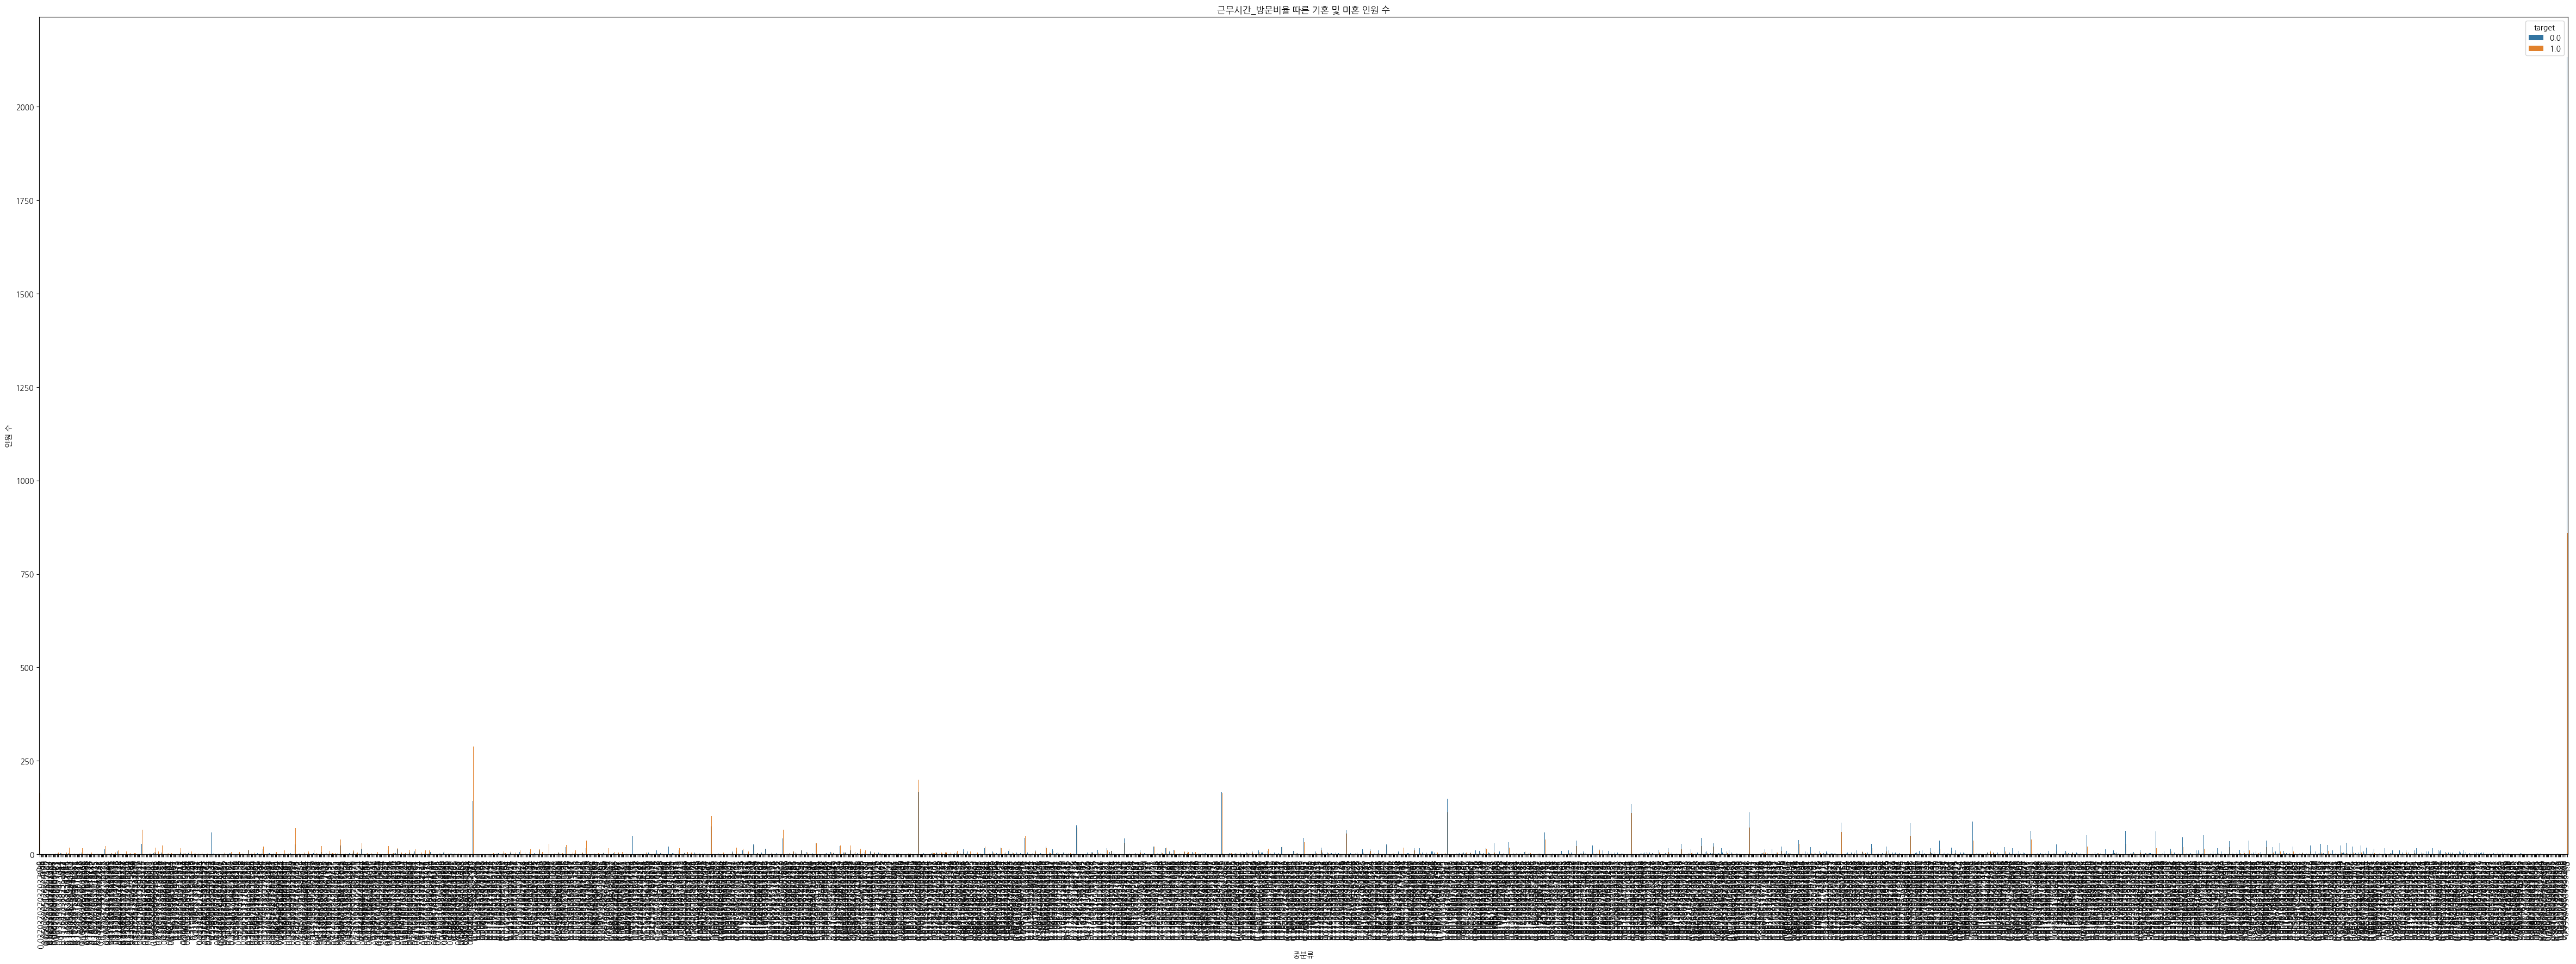

In [64]:
plt.figure(figsize=(60,20))
sns.countplot(data=train_ft, x='근무시간_방문비율', hue='target')

plt.title('근무시간_방문비율 따른 기혼 및 미혼 인원 수')
plt.xticks(rotation=90)
plt.xlabel('중분류')
plt.ylabel('인원 수')
plt.show()

In [121]:
submit.to_csv("정재연18차.csv",index=False)

In [156]:
import catboost
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# CatBoost 모델 초기화
model_cat = catboost.CatBoostClassifier(eval_metric='AUC')

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'depth': randint(1, 5),
    'learning_rate': loguniform(1e-3, 0.1),
    'min_child_samples': randint(10, 40),
    'grow_policy': ['SymmetricTree', 'Lossguide', 'Depthwise']
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_cat,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=3,
    n_iter=10,
    random_state=42
)

# 무작위 탐색 수행
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 하이퍼파라미터로 모델 설정
best_model_cat = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
pred = best_model_cat.predict_proba(Y_scaled)  # 클래스 1의 확률값 추출

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

0:	total: 9.72ms	remaining: 2.79s
1:	total: 20.5ms	remaining: 2.93s
2:	total: 27.8ms	remaining: 2.64s
3:	total: 35.4ms	remaining: 2.52s
4:	total: 42.5ms	remaining: 2.41s
5:	total: 49.8ms	remaining: 2.34s
6:	total: 56.5ms	remaining: 2.27s
7:	total: 62.9ms	remaining: 2.2s
8:	total: 70.2ms	remaining: 2.17s
9:	total: 77.4ms	remaining: 2.15s
10:	total: 85.6ms	remaining: 2.15s
11:	total: 92.3ms	remaining: 2.12s
12:	total: 98.5ms	remaining: 2.08s
13:	total: 105ms	remaining: 2.05s
14:	total: 111ms	remaining: 2.02s
15:	total: 117ms	remaining: 1.99s
16:	total: 124ms	remaining: 1.97s
17:	total: 130ms	remaining: 1.96s
18:	total: 137ms	remaining: 1.94s
19:	total: 144ms	remaining: 1.94s
20:	total: 151ms	remaining: 1.92s
21:	total: 158ms	remaining: 1.91s
22:	total: 166ms	remaining: 1.92s
23:	total: 173ms	remaining: 1.91s
24:	total: 180ms	remaining: 1.9s
25:	total: 186ms	remaining: 1.88s
26:	total: 193ms	remaining: 1.87s
27:	total: 199ms	remaining: 1.85s
28:	total: 205ms	remaining: 1.83s
29:	total: 21

265:	total: 1.89s	remaining: 156ms
266:	total: 1.89s	remaining: 149ms
267:	total: 1.9s	remaining: 142ms
268:	total: 1.91s	remaining: 135ms
269:	total: 1.92s	remaining: 128ms
270:	total: 1.92s	remaining: 121ms
271:	total: 1.93s	remaining: 114ms
272:	total: 1.94s	remaining: 107ms
273:	total: 1.95s	remaining: 99.5ms
274:	total: 1.95s	remaining: 92.4ms
275:	total: 1.96s	remaining: 85.3ms
276:	total: 1.97s	remaining: 78.2ms
277:	total: 1.98s	remaining: 71.1ms
278:	total: 1.98s	remaining: 64ms
279:	total: 1.99s	remaining: 56.9ms
280:	total: 2s	remaining: 49.8ms
281:	total: 2s	remaining: 42.6ms
282:	total: 2.01s	remaining: 35.5ms
283:	total: 2.02s	remaining: 28.4ms
284:	total: 2.03s	remaining: 21.3ms
285:	total: 2.03s	remaining: 14.2ms
286:	total: 2.04s	remaining: 7.11ms
287:	total: 2.05s	remaining: 0us
0:	total: 8.46ms	remaining: 2.43s
1:	total: 15.3ms	remaining: 2.19s
2:	total: 23ms	remaining: 2.19s
3:	total: 30ms	remaining: 2.13s
4:	total: 39.2ms	remaining: 2.22s
5:	total: 46.2ms	remaining

217:	total: 1.45s	remaining: 465ms
218:	total: 1.45s	remaining: 458ms
219:	total: 1.46s	remaining: 451ms
220:	total: 1.47s	remaining: 445ms
221:	total: 1.47s	remaining: 438ms
222:	total: 1.48s	remaining: 431ms
223:	total: 1.49s	remaining: 425ms
224:	total: 1.49s	remaining: 418ms
225:	total: 1.5s	remaining: 411ms
226:	total: 1.5s	remaining: 404ms
227:	total: 1.51s	remaining: 398ms
228:	total: 1.52s	remaining: 391ms
229:	total: 1.52s	remaining: 384ms
230:	total: 1.53s	remaining: 377ms
231:	total: 1.53s	remaining: 371ms
232:	total: 1.54s	remaining: 364ms
233:	total: 1.55s	remaining: 357ms
234:	total: 1.55s	remaining: 351ms
235:	total: 1.56s	remaining: 344ms
236:	total: 1.57s	remaining: 337ms
237:	total: 1.57s	remaining: 330ms
238:	total: 1.58s	remaining: 324ms
239:	total: 1.58s	remaining: 317ms
240:	total: 1.59s	remaining: 310ms
241:	total: 1.6s	remaining: 304ms
242:	total: 1.6s	remaining: 297ms
243:	total: 1.61s	remaining: 290ms
244:	total: 1.61s	remaining: 283ms
245:	total: 1.62s	remain

171:	total: 1.1s	remaining: 746ms
172:	total: 1.11s	remaining: 739ms
173:	total: 1.12s	remaining: 732ms
174:	total: 1.12s	remaining: 726ms
175:	total: 1.13s	remaining: 720ms
176:	total: 1.14s	remaining: 714ms
177:	total: 1.14s	remaining: 707ms
178:	total: 1.15s	remaining: 700ms
179:	total: 1.16s	remaining: 694ms
180:	total: 1.16s	remaining: 687ms
181:	total: 1.17s	remaining: 680ms
182:	total: 1.17s	remaining: 674ms
183:	total: 1.18s	remaining: 667ms
184:	total: 1.19s	remaining: 660ms
185:	total: 1.19s	remaining: 654ms
186:	total: 1.2s	remaining: 648ms
187:	total: 1.21s	remaining: 641ms
188:	total: 1.21s	remaining: 635ms
189:	total: 1.22s	remaining: 628ms
190:	total: 1.22s	remaining: 622ms
191:	total: 1.23s	remaining: 615ms
192:	total: 1.24s	remaining: 609ms
193:	total: 1.24s	remaining: 602ms
194:	total: 1.25s	remaining: 595ms
195:	total: 1.25s	remaining: 588ms
196:	total: 1.26s	remaining: 582ms
197:	total: 1.27s	remaining: 576ms
198:	total: 1.27s	remaining: 569ms
199:	total: 1.28s	rema

122:	total: 610ms	remaining: 253ms
123:	total: 616ms	remaining: 248ms
124:	total: 621ms	remaining: 244ms
125:	total: 628ms	remaining: 239ms
126:	total: 633ms	remaining: 234ms
127:	total: 637ms	remaining: 229ms
128:	total: 642ms	remaining: 224ms
129:	total: 646ms	remaining: 219ms
130:	total: 652ms	remaining: 214ms
131:	total: 657ms	remaining: 209ms
132:	total: 662ms	remaining: 204ms
133:	total: 666ms	remaining: 199ms
134:	total: 671ms	remaining: 194ms
135:	total: 676ms	remaining: 189ms
136:	total: 680ms	remaining: 184ms
137:	total: 685ms	remaining: 179ms
138:	total: 690ms	remaining: 174ms
139:	total: 694ms	remaining: 169ms
140:	total: 698ms	remaining: 163ms
141:	total: 703ms	remaining: 158ms
142:	total: 709ms	remaining: 154ms
143:	total: 714ms	remaining: 149ms
144:	total: 719ms	remaining: 144ms
145:	total: 723ms	remaining: 139ms
146:	total: 727ms	remaining: 134ms
147:	total: 732ms	remaining: 129ms
148:	total: 738ms	remaining: 124ms
149:	total: 743ms	remaining: 119ms
150:	total: 747ms	re

41:	total: 198ms	remaining: 622ms
42:	total: 205ms	remaining: 623ms
43:	total: 209ms	remaining: 618ms
44:	total: 214ms	remaining: 613ms
45:	total: 219ms	remaining: 609ms
46:	total: 224ms	remaining: 604ms
47:	total: 229ms	remaining: 600ms
48:	total: 233ms	remaining: 595ms
49:	total: 238ms	remaining: 589ms
50:	total: 242ms	remaining: 584ms
51:	total: 247ms	remaining: 579ms
52:	total: 251ms	remaining: 573ms
53:	total: 255ms	remaining: 567ms
54:	total: 260ms	remaining: 563ms
55:	total: 264ms	remaining: 557ms
56:	total: 269ms	remaining: 551ms
57:	total: 273ms	remaining: 546ms
58:	total: 277ms	remaining: 540ms
59:	total: 281ms	remaining: 535ms
60:	total: 286ms	remaining: 530ms
61:	total: 292ms	remaining: 527ms
62:	total: 297ms	remaining: 524ms
63:	total: 302ms	remaining: 518ms
64:	total: 306ms	remaining: 514ms
65:	total: 311ms	remaining: 509ms
66:	total: 316ms	remaining: 505ms
67:	total: 322ms	remaining: 501ms
68:	total: 327ms	remaining: 497ms
69:	total: 331ms	remaining: 492ms
70:	total: 336

126:	total: 872ms	remaining: 708ms
127:	total: 879ms	remaining: 701ms
128:	total: 886ms	remaining: 694ms
129:	total: 894ms	remaining: 688ms
130:	total: 902ms	remaining: 681ms
131:	total: 908ms	remaining: 674ms
132:	total: 915ms	remaining: 667ms
133:	total: 921ms	remaining: 660ms
134:	total: 929ms	remaining: 653ms
135:	total: 935ms	remaining: 646ms
136:	total: 942ms	remaining: 640ms
137:	total: 949ms	remaining: 633ms
138:	total: 955ms	remaining: 625ms
139:	total: 962ms	remaining: 618ms
140:	total: 968ms	remaining: 611ms
141:	total: 975ms	remaining: 604ms
142:	total: 981ms	remaining: 597ms
143:	total: 988ms	remaining: 590ms
144:	total: 995ms	remaining: 583ms
145:	total: 1s	remaining: 576ms
146:	total: 1.01s	remaining: 570ms
147:	total: 1.01s	remaining: 563ms
148:	total: 1.02s	remaining: 556ms
149:	total: 1.03s	remaining: 549ms
150:	total: 1.03s	remaining: 541ms
151:	total: 1.04s	remaining: 534ms
152:	total: 1.05s	remaining: 528ms
153:	total: 1.06s	remaining: 521ms
154:	total: 1.06s	remai

158:	total: 1.02s	remaining: 458ms
159:	total: 1.03s	remaining: 452ms
160:	total: 1.04s	remaining: 445ms
161:	total: 1.05s	remaining: 439ms
162:	total: 1.05s	remaining: 433ms
163:	total: 1.06s	remaining: 426ms
164:	total: 1.06s	remaining: 420ms
165:	total: 1.07s	remaining: 413ms
166:	total: 1.08s	remaining: 407ms
167:	total: 1.08s	remaining: 401ms
168:	total: 1.09s	remaining: 394ms
169:	total: 1.1s	remaining: 387ms
170:	total: 1.1s	remaining: 381ms
171:	total: 1.11s	remaining: 375ms
172:	total: 1.12s	remaining: 369ms
173:	total: 1.13s	remaining: 362ms
174:	total: 1.13s	remaining: 356ms
175:	total: 1.14s	remaining: 349ms
176:	total: 1.15s	remaining: 343ms
177:	total: 1.15s	remaining: 336ms
178:	total: 1.16s	remaining: 330ms
179:	total: 1.16s	remaining: 323ms
180:	total: 1.17s	remaining: 317ms
181:	total: 1.18s	remaining: 311ms
182:	total: 1.18s	remaining: 304ms
183:	total: 1.19s	remaining: 298ms
184:	total: 1.2s	remaining: 292ms
185:	total: 1.21s	remaining: 285ms
186:	total: 1.21s	remai

188:	total: 1.28s	remaining: 279ms
189:	total: 1.29s	remaining: 272ms
190:	total: 1.3s	remaining: 266ms
191:	total: 1.31s	remaining: 259ms
192:	total: 1.31s	remaining: 252ms
193:	total: 1.32s	remaining: 245ms
194:	total: 1.33s	remaining: 238ms
195:	total: 1.33s	remaining: 231ms
196:	total: 1.34s	remaining: 225ms
197:	total: 1.35s	remaining: 218ms
198:	total: 1.35s	remaining: 211ms
199:	total: 1.36s	remaining: 204ms
200:	total: 1.37s	remaining: 197ms
201:	total: 1.37s	remaining: 191ms
202:	total: 1.38s	remaining: 184ms
203:	total: 1.39s	remaining: 177ms
204:	total: 1.39s	remaining: 170ms
205:	total: 1.4s	remaining: 163ms
206:	total: 1.41s	remaining: 156ms
207:	total: 1.41s	remaining: 149ms
208:	total: 1.42s	remaining: 143ms
209:	total: 1.43s	remaining: 136ms
210:	total: 1.44s	remaining: 129ms
211:	total: 1.44s	remaining: 122ms
212:	total: 1.45s	remaining: 116ms
213:	total: 1.45s	remaining: 109ms
214:	total: 1.46s	remaining: 102ms
215:	total: 1.47s	remaining: 95.2ms
216:	total: 1.47s	rem

211:	total: 1.24s	remaining: 263ms
212:	total: 1.24s	remaining: 257ms
213:	total: 1.25s	remaining: 251ms
214:	total: 1.25s	remaining: 245ms
215:	total: 1.26s	remaining: 239ms
216:	total: 1.27s	remaining: 233ms
217:	total: 1.27s	remaining: 228ms
218:	total: 1.28s	remaining: 222ms
219:	total: 1.29s	remaining: 216ms
220:	total: 1.29s	remaining: 211ms
221:	total: 1.3s	remaining: 205ms
222:	total: 1.3s	remaining: 199ms
223:	total: 1.31s	remaining: 193ms
224:	total: 1.32s	remaining: 187ms
225:	total: 1.32s	remaining: 182ms
226:	total: 1.33s	remaining: 176ms
227:	total: 1.33s	remaining: 170ms
228:	total: 1.34s	remaining: 164ms
229:	total: 1.35s	remaining: 158ms
230:	total: 1.35s	remaining: 152ms
231:	total: 1.36s	remaining: 146ms
232:	total: 1.36s	remaining: 140ms
233:	total: 1.37s	remaining: 134ms
234:	total: 1.37s	remaining: 129ms
235:	total: 1.38s	remaining: 123ms
236:	total: 1.39s	remaining: 117ms
237:	total: 1.39s	remaining: 111ms
238:	total: 1.4s	remaining: 106ms
239:	total: 1.41s	remai

217:	total: 1.23s	remaining: 221ms
218:	total: 1.24s	remaining: 215ms
219:	total: 1.25s	remaining: 210ms
220:	total: 1.25s	remaining: 204ms
221:	total: 1.26s	remaining: 199ms
222:	total: 1.27s	remaining: 193ms
223:	total: 1.27s	remaining: 187ms
224:	total: 1.28s	remaining: 182ms
225:	total: 1.28s	remaining: 176ms
226:	total: 1.29s	remaining: 170ms
227:	total: 1.3s	remaining: 165ms
228:	total: 1.3s	remaining: 159ms
229:	total: 1.31s	remaining: 154ms
230:	total: 1.31s	remaining: 148ms
231:	total: 1.32s	remaining: 142ms
232:	total: 1.33s	remaining: 137ms
233:	total: 1.33s	remaining: 131ms
234:	total: 1.34s	remaining: 125ms
235:	total: 1.34s	remaining: 120ms
236:	total: 1.35s	remaining: 114ms
237:	total: 1.35s	remaining: 108ms
238:	total: 1.36s	remaining: 103ms
239:	total: 1.37s	remaining: 96.9ms
240:	total: 1.37s	remaining: 91.2ms
241:	total: 1.38s	remaining: 85.5ms
242:	total: 1.38s	remaining: 79.7ms
243:	total: 1.39s	remaining: 74ms
244:	total: 1.4s	remaining: 68.4ms
245:	total: 1.4s	re

225:	total: 1.28s	remaining: 175ms
226:	total: 1.28s	remaining: 169ms
227:	total: 1.29s	remaining: 164ms
228:	total: 1.29s	remaining: 158ms
229:	total: 1.3s	remaining: 152ms
230:	total: 1.3s	remaining: 147ms
231:	total: 1.31s	remaining: 141ms
232:	total: 1.31s	remaining: 135ms
233:	total: 1.32s	remaining: 130ms
234:	total: 1.33s	remaining: 124ms
235:	total: 1.33s	remaining: 118ms
236:	total: 1.34s	remaining: 113ms
237:	total: 1.34s	remaining: 107ms
238:	total: 1.35s	remaining: 102ms
239:	total: 1.36s	remaining: 96.1ms
240:	total: 1.36s	remaining: 90.4ms
241:	total: 1.37s	remaining: 84.8ms
242:	total: 1.37s	remaining: 79.1ms
243:	total: 1.38s	remaining: 73.5ms
244:	total: 1.39s	remaining: 67.9ms
245:	total: 1.39s	remaining: 62.2ms
246:	total: 1.4s	remaining: 56.5ms
247:	total: 1.4s	remaining: 50.8ms
248:	total: 1.41s	remaining: 45.2ms
249:	total: 1.41s	remaining: 39.6ms
250:	total: 1.42s	remaining: 34ms
251:	total: 1.43s	remaining: 28.3ms
252:	total: 1.43s	remaining: 22.6ms
253:	total: 

222:	total: 1.45s	remaining: 241ms
223:	total: 1.46s	remaining: 235ms
224:	total: 1.47s	remaining: 228ms
225:	total: 1.47s	remaining: 222ms
226:	total: 1.48s	remaining: 215ms
227:	total: 1.49s	remaining: 209ms
228:	total: 1.49s	remaining: 202ms
229:	total: 1.5s	remaining: 195ms
230:	total: 1.51s	remaining: 189ms
231:	total: 1.51s	remaining: 183ms
232:	total: 1.52s	remaining: 176ms
233:	total: 1.52s	remaining: 170ms
234:	total: 1.53s	remaining: 163ms
235:	total: 1.54s	remaining: 156ms
236:	total: 1.54s	remaining: 150ms
237:	total: 1.55s	remaining: 143ms
238:	total: 1.56s	remaining: 137ms
239:	total: 1.56s	remaining: 130ms
240:	total: 1.57s	remaining: 124ms
241:	total: 1.58s	remaining: 117ms
242:	total: 1.58s	remaining: 111ms
243:	total: 1.59s	remaining: 104ms
244:	total: 1.6s	remaining: 97.9ms
245:	total: 1.61s	remaining: 91.5ms
246:	total: 1.61s	remaining: 84.9ms
247:	total: 1.62s	remaining: 78.6ms
248:	total: 1.63s	remaining: 72.1ms
249:	total: 1.64s	remaining: 65.6ms
250:	total: 1.65

225:	total: 1.45s	remaining: 219ms
226:	total: 1.46s	remaining: 212ms
227:	total: 1.47s	remaining: 206ms
228:	total: 1.47s	remaining: 199ms
229:	total: 1.48s	remaining: 193ms
230:	total: 1.49s	remaining: 186ms
231:	total: 1.49s	remaining: 180ms
232:	total: 1.5s	remaining: 174ms
233:	total: 1.5s	remaining: 167ms
234:	total: 1.51s	remaining: 161ms
235:	total: 1.52s	remaining: 154ms
236:	total: 1.52s	remaining: 148ms
237:	total: 1.53s	remaining: 142ms
238:	total: 1.54s	remaining: 135ms
239:	total: 1.55s	remaining: 129ms
240:	total: 1.56s	remaining: 123ms
241:	total: 1.58s	remaining: 118ms
242:	total: 1.59s	remaining: 111ms
243:	total: 1.6s	remaining: 105ms
244:	total: 1.61s	remaining: 98.5ms
245:	total: 1.62s	remaining: 92.2ms
246:	total: 1.63s	remaining: 85.6ms
247:	total: 1.63s	remaining: 79.1ms
248:	total: 1.64s	remaining: 72.5ms
249:	total: 1.65s	remaining: 66ms
250:	total: 1.66s	remaining: 59.5ms
251:	total: 1.67s	remaining: 52.9ms
252:	total: 1.68s	remaining: 46.4ms
253:	total: 1.68

224:	total: 1.44s	remaining: 224ms
225:	total: 1.45s	remaining: 217ms
226:	total: 1.45s	remaining: 211ms
227:	total: 1.46s	remaining: 205ms
228:	total: 1.46s	remaining: 198ms
229:	total: 1.47s	remaining: 192ms
230:	total: 1.48s	remaining: 185ms
231:	total: 1.48s	remaining: 179ms
232:	total: 1.49s	remaining: 173ms
233:	total: 1.49s	remaining: 166ms
234:	total: 1.5s	remaining: 160ms
235:	total: 1.51s	remaining: 153ms
236:	total: 1.51s	remaining: 147ms
237:	total: 1.52s	remaining: 141ms
238:	total: 1.53s	remaining: 134ms
239:	total: 1.53s	remaining: 128ms
240:	total: 1.54s	remaining: 121ms
241:	total: 1.54s	remaining: 115ms
242:	total: 1.55s	remaining: 109ms
243:	total: 1.56s	remaining: 102ms
244:	total: 1.56s	remaining: 95.8ms
245:	total: 1.57s	remaining: 89.4ms
246:	total: 1.58s	remaining: 83ms
247:	total: 1.58s	remaining: 76.5ms
248:	total: 1.59s	remaining: 70.2ms
249:	total: 1.59s	remaining: 63.8ms
250:	total: 1.6s	remaining: 57.4ms
251:	total: 1.61s	remaining: 51ms
252:	total: 1.61s	

15:	total: 235ms	remaining: 2.52s
16:	total: 251ms	remaining: 2.52s
17:	total: 265ms	remaining: 2.5s
18:	total: 281ms	remaining: 2.5s
19:	total: 296ms	remaining: 2.49s
20:	total: 311ms	remaining: 2.47s
21:	total: 325ms	remaining: 2.45s
22:	total: 338ms	remaining: 2.42s
23:	total: 351ms	remaining: 2.4s
24:	total: 366ms	remaining: 2.38s
25:	total: 379ms	remaining: 2.36s
26:	total: 395ms	remaining: 2.35s
27:	total: 409ms	remaining: 2.34s
28:	total: 425ms	remaining: 2.33s
29:	total: 441ms	remaining: 2.32s
30:	total: 460ms	remaining: 2.33s
31:	total: 476ms	remaining: 2.32s
32:	total: 492ms	remaining: 2.31s
33:	total: 509ms	remaining: 2.31s
34:	total: 525ms	remaining: 2.29s
35:	total: 540ms	remaining: 2.28s
36:	total: 557ms	remaining: 2.27s
37:	total: 572ms	remaining: 2.26s
38:	total: 588ms	remaining: 2.24s
39:	total: 603ms	remaining: 2.23s
40:	total: 617ms	remaining: 2.21s
41:	total: 631ms	remaining: 2.19s
42:	total: 644ms	remaining: 2.17s
43:	total: 660ms	remaining: 2.16s
44:	total: 676ms	

72:	total: 1.09s	remaining: 1.72s
73:	total: 1.11s	remaining: 1.71s
74:	total: 1.12s	remaining: 1.69s
75:	total: 1.14s	remaining: 1.68s
76:	total: 1.15s	remaining: 1.66s
77:	total: 1.17s	remaining: 1.65s
78:	total: 1.19s	remaining: 1.64s
79:	total: 1.2s	remaining: 1.62s
80:	total: 1.22s	remaining: 1.61s
81:	total: 1.23s	remaining: 1.59s
82:	total: 1.25s	remaining: 1.58s
83:	total: 1.26s	remaining: 1.56s
84:	total: 1.28s	remaining: 1.55s
85:	total: 1.29s	remaining: 1.53s
86:	total: 1.31s	remaining: 1.52s
87:	total: 1.32s	remaining: 1.5s
88:	total: 1.34s	remaining: 1.49s
89:	total: 1.35s	remaining: 1.47s
90:	total: 1.37s	remaining: 1.46s
91:	total: 1.39s	remaining: 1.45s
92:	total: 1.4s	remaining: 1.43s
93:	total: 1.41s	remaining: 1.41s
94:	total: 1.43s	remaining: 1.4s
95:	total: 1.44s	remaining: 1.38s
96:	total: 1.46s	remaining: 1.37s
97:	total: 1.47s	remaining: 1.35s
98:	total: 1.49s	remaining: 1.34s
99:	total: 1.5s	remaining: 1.32s
100:	total: 1.52s	remaining: 1.31s
101:	total: 1.54s	

125:	total: 606ms	remaining: 775ms
126:	total: 611ms	remaining: 770ms
127:	total: 615ms	remaining: 764ms
128:	total: 620ms	remaining: 759ms
129:	total: 624ms	remaining: 754ms
130:	total: 629ms	remaining: 749ms
131:	total: 633ms	remaining: 743ms
132:	total: 637ms	remaining: 738ms
133:	total: 643ms	remaining: 734ms
134:	total: 647ms	remaining: 729ms
135:	total: 652ms	remaining: 724ms
136:	total: 657ms	remaining: 719ms
137:	total: 661ms	remaining: 714ms
138:	total: 666ms	remaining: 709ms
139:	total: 670ms	remaining: 704ms
140:	total: 674ms	remaining: 698ms
141:	total: 680ms	remaining: 694ms
142:	total: 685ms	remaining: 690ms
143:	total: 690ms	remaining: 685ms
144:	total: 695ms	remaining: 680ms
145:	total: 701ms	remaining: 677ms
146:	total: 708ms	remaining: 674ms
147:	total: 716ms	remaining: 672ms
148:	total: 722ms	remaining: 668ms
149:	total: 727ms	remaining: 664ms
150:	total: 732ms	remaining: 660ms
151:	total: 738ms	remaining: 655ms
152:	total: 744ms	remaining: 652ms
153:	total: 752ms	re

90:	total: 396ms	remaining: 852ms
91:	total: 401ms	remaining: 850ms
92:	total: 406ms	remaining: 846ms
93:	total: 410ms	remaining: 842ms
94:	total: 414ms	remaining: 837ms
95:	total: 419ms	remaining: 834ms
96:	total: 424ms	remaining: 830ms
97:	total: 428ms	remaining: 826ms
98:	total: 433ms	remaining: 822ms
99:	total: 437ms	remaining: 818ms
100:	total: 443ms	remaining: 816ms
101:	total: 448ms	remaining: 812ms
102:	total: 452ms	remaining: 807ms
103:	total: 456ms	remaining: 803ms
104:	total: 460ms	remaining: 798ms
105:	total: 465ms	remaining: 793ms
106:	total: 469ms	remaining: 789ms
107:	total: 474ms	remaining: 785ms
108:	total: 478ms	remaining: 781ms
109:	total: 482ms	remaining: 776ms
110:	total: 487ms	remaining: 772ms
111:	total: 491ms	remaining: 767ms
112:	total: 495ms	remaining: 762ms
113:	total: 500ms	remaining: 759ms
114:	total: 504ms	remaining: 754ms
115:	total: 508ms	remaining: 750ms
116:	total: 513ms	remaining: 746ms
117:	total: 519ms	remaining: 744ms
118:	total: 524ms	remaining: 7

44:	total: 208ms	remaining: 1.12s
45:	total: 213ms	remaining: 1.11s
46:	total: 217ms	remaining: 1.11s
47:	total: 221ms	remaining: 1.1s
48:	total: 226ms	remaining: 1.1s
49:	total: 231ms	remaining: 1.09s
50:	total: 236ms	remaining: 1.09s
51:	total: 240ms	remaining: 1.08s
52:	total: 244ms	remaining: 1.08s
53:	total: 248ms	remaining: 1.07s
54:	total: 253ms	remaining: 1.06s
55:	total: 258ms	remaining: 1.06s
56:	total: 262ms	remaining: 1.06s
57:	total: 266ms	remaining: 1.05s
58:	total: 271ms	remaining: 1.05s
59:	total: 275ms	remaining: 1.04s
60:	total: 280ms	remaining: 1.04s
61:	total: 285ms	remaining: 1.03s
62:	total: 289ms	remaining: 1.03s
63:	total: 293ms	remaining: 1.02s
64:	total: 297ms	remaining: 1.01s
65:	total: 301ms	remaining: 1.01s
66:	total: 305ms	remaining: 1s
67:	total: 310ms	remaining: 998ms
68:	total: 315ms	remaining: 994ms
69:	total: 319ms	remaining: 990ms
70:	total: 324ms	remaining: 985ms
71:	total: 328ms	remaining: 979ms
72:	total: 333ms	remaining: 977ms
73:	total: 338ms	re

0:	total: 13.9ms	remaining: 4.01s
1:	total: 26.2ms	remaining: 3.77s
2:	total: 38.3ms	remaining: 3.65s
3:	total: 51.4ms	remaining: 3.66s
4:	total: 63.7ms	remaining: 3.62s
5:	total: 75.5ms	remaining: 3.56s
6:	total: 87.1ms	remaining: 3.51s
7:	total: 98.4ms	remaining: 3.46s
8:	total: 110ms	remaining: 3.42s
9:	total: 123ms	remaining: 3.42s
10:	total: 135ms	remaining: 3.42s
11:	total: 146ms	remaining: 3.38s
12:	total: 159ms	remaining: 3.37s
13:	total: 170ms	remaining: 3.34s
14:	total: 181ms	remaining: 3.31s
15:	total: 193ms	remaining: 3.3s
16:	total: 207ms	remaining: 3.31s
17:	total: 220ms	remaining: 3.31s
18:	total: 232ms	remaining: 3.29s
19:	total: 243ms	remaining: 3.26s
20:	total: 256ms	remaining: 3.27s
21:	total: 267ms	remaining: 3.24s
22:	total: 279ms	remaining: 3.22s
23:	total: 290ms	remaining: 3.2s
24:	total: 302ms	remaining: 3.19s
25:	total: 315ms	remaining: 3.19s
26:	total: 328ms	remaining: 3.18s
27:	total: 340ms	remaining: 3.17s
28:	total: 351ms	remaining: 3.14s
29:	total: 362ms	r

240:	total: 3.18s	remaining: 633ms
241:	total: 3.19s	remaining: 619ms
242:	total: 3.2s	remaining: 606ms
243:	total: 3.21s	remaining: 592ms
244:	total: 3.23s	remaining: 579ms
245:	total: 3.24s	remaining: 566ms
246:	total: 3.25s	remaining: 553ms
247:	total: 3.26s	remaining: 539ms
248:	total: 3.27s	remaining: 526ms
249:	total: 3.29s	remaining: 513ms
250:	total: 3.3s	remaining: 500ms
251:	total: 3.31s	remaining: 487ms
252:	total: 3.33s	remaining: 473ms
253:	total: 3.34s	remaining: 460ms
254:	total: 3.35s	remaining: 447ms
255:	total: 3.37s	remaining: 434ms
256:	total: 3.38s	remaining: 421ms
257:	total: 3.39s	remaining: 408ms
258:	total: 3.41s	remaining: 395ms
259:	total: 3.42s	remaining: 381ms
260:	total: 3.43s	remaining: 368ms
261:	total: 3.44s	remaining: 355ms
262:	total: 3.46s	remaining: 342ms
263:	total: 3.47s	remaining: 329ms
264:	total: 3.48s	remaining: 316ms
265:	total: 3.5s	remaining: 303ms
266:	total: 3.51s	remaining: 289ms
267:	total: 3.53s	remaining: 276ms
268:	total: 3.54s	remai

201:	total: 2.82s	remaining: 1.21s
202:	total: 2.83s	remaining: 1.2s
203:	total: 2.85s	remaining: 1.19s
204:	total: 2.86s	remaining: 1.17s
205:	total: 2.87s	remaining: 1.16s
206:	total: 2.88s	remaining: 1.14s
207:	total: 2.9s	remaining: 1.13s
208:	total: 2.91s	remaining: 1.11s
209:	total: 2.92s	remaining: 1.1s
210:	total: 2.94s	remaining: 1.08s
211:	total: 2.95s	remaining: 1.07s
212:	total: 2.96s	remaining: 1.06s
213:	total: 2.97s	remaining: 1.04s
214:	total: 2.99s	remaining: 1.03s
215:	total: 3s	remaining: 1.01s
216:	total: 3.01s	remaining: 999ms
217:	total: 3.02s	remaining: 984ms
218:	total: 3.04s	remaining: 971ms
219:	total: 3.05s	remaining: 956ms
220:	total: 3.06s	remaining: 942ms
221:	total: 3.07s	remaining: 928ms
222:	total: 3.09s	remaining: 914ms
223:	total: 3.1s	remaining: 900ms
224:	total: 3.11s	remaining: 886ms
225:	total: 3.13s	remaining: 871ms
226:	total: 3.14s	remaining: 857ms
227:	total: 3.15s	remaining: 843ms
228:	total: 3.16s	remaining: 829ms
229:	total: 3.17s	remaining

151:	total: 1.92s	remaining: 1.73s
152:	total: 1.94s	remaining: 1.72s
153:	total: 1.95s	remaining: 1.71s
154:	total: 1.97s	remaining: 1.7s
155:	total: 1.98s	remaining: 1.69s
156:	total: 2s	remaining: 1.68s
157:	total: 2.01s	remaining: 1.67s
158:	total: 2.03s	remaining: 1.66s
159:	total: 2.04s	remaining: 1.64s
160:	total: 2.05s	remaining: 1.63s
161:	total: 2.06s	remaining: 1.62s
162:	total: 2.08s	remaining: 1.6s
163:	total: 2.09s	remaining: 1.59s
164:	total: 2.1s	remaining: 1.58s
165:	total: 2.11s	remaining: 1.57s
166:	total: 2.13s	remaining: 1.55s
167:	total: 2.14s	remaining: 1.54s
168:	total: 2.15s	remaining: 1.53s
169:	total: 2.17s	remaining: 1.52s
170:	total: 2.18s	remaining: 1.51s
171:	total: 2.2s	remaining: 1.49s
172:	total: 2.21s	remaining: 1.48s
173:	total: 2.22s	remaining: 1.47s
174:	total: 2.23s	remaining: 1.45s
175:	total: 2.25s	remaining: 1.44s
176:	total: 2.26s	remaining: 1.43s
177:	total: 2.27s	remaining: 1.42s
178:	total: 2.28s	remaining: 1.4s
179:	total: 2.29s	remaining:

107:	total: 1.04s	remaining: 1.18s
108:	total: 1.05s	remaining: 1.17s
109:	total: 1.06s	remaining: 1.16s
110:	total: 1.07s	remaining: 1.15s
111:	total: 1.08s	remaining: 1.13s
112:	total: 1.08s	remaining: 1.12s
113:	total: 1.09s	remaining: 1.11s
114:	total: 1.1s	remaining: 1.1s
115:	total: 1.11s	remaining: 1.09s
116:	total: 1.12s	remaining: 1.08s
117:	total: 1.13s	remaining: 1.07s
118:	total: 1.14s	remaining: 1.06s
119:	total: 1.15s	remaining: 1.05s
120:	total: 1.15s	remaining: 1.04s
121:	total: 1.16s	remaining: 1.03s
122:	total: 1.17s	remaining: 1.02s
123:	total: 1.18s	remaining: 1.01s
124:	total: 1.19s	remaining: 1s
125:	total: 1.2s	remaining: 991ms
126:	total: 1.21s	remaining: 981ms
127:	total: 1.22s	remaining: 972ms
128:	total: 1.23s	remaining: 962ms
129:	total: 1.24s	remaining: 951ms
130:	total: 1.25s	remaining: 941ms
131:	total: 1.25s	remaining: 931ms
132:	total: 1.26s	remaining: 921ms
133:	total: 1.27s	remaining: 911ms
134:	total: 1.28s	remaining: 901ms
135:	total: 1.29s	remainin

120:	total: 1.06s	remaining: 958ms
121:	total: 1.07s	remaining: 949ms
122:	total: 1.08s	remaining: 940ms
123:	total: 1.09s	remaining: 933ms
124:	total: 1.1s	remaining: 924ms
125:	total: 1.11s	remaining: 915ms
126:	total: 1.12s	remaining: 906ms
127:	total: 1.13s	remaining: 897ms
128:	total: 1.13s	remaining: 887ms
129:	total: 1.14s	remaining: 878ms
130:	total: 1.15s	remaining: 868ms
131:	total: 1.16s	remaining: 860ms
132:	total: 1.17s	remaining: 850ms
133:	total: 1.17s	remaining: 841ms
134:	total: 1.18s	remaining: 832ms
135:	total: 1.19s	remaining: 822ms
136:	total: 1.2s	remaining: 813ms
137:	total: 1.21s	remaining: 805ms
138:	total: 1.22s	remaining: 796ms
139:	total: 1.22s	remaining: 787ms
140:	total: 1.23s	remaining: 779ms
141:	total: 1.24s	remaining: 770ms
142:	total: 1.25s	remaining: 760ms
143:	total: 1.26s	remaining: 752ms
144:	total: 1.27s	remaining: 743ms
145:	total: 1.28s	remaining: 735ms
146:	total: 1.29s	remaining: 726ms
147:	total: 1.29s	remaining: 718ms
148:	total: 1.3s	remai

142:	total: 1.24s	remaining: 757ms
143:	total: 1.25s	remaining: 748ms
144:	total: 1.26s	remaining: 739ms
145:	total: 1.27s	remaining: 732ms
146:	total: 1.28s	remaining: 724ms
147:	total: 1.29s	remaining: 714ms
148:	total: 1.3s	remaining: 705ms
149:	total: 1.3s	remaining: 696ms
150:	total: 1.31s	remaining: 687ms
151:	total: 1.32s	remaining: 677ms
152:	total: 1.33s	remaining: 668ms
153:	total: 1.34s	remaining: 660ms
154:	total: 1.34s	remaining: 651ms
155:	total: 1.35s	remaining: 643ms
156:	total: 1.36s	remaining: 634ms
157:	total: 1.37s	remaining: 625ms
158:	total: 1.38s	remaining: 616ms
159:	total: 1.39s	remaining: 607ms
160:	total: 1.4s	remaining: 599ms
161:	total: 1.41s	remaining: 590ms
162:	total: 1.42s	remaining: 582ms
163:	total: 1.43s	remaining: 574ms
164:	total: 1.44s	remaining: 566ms
165:	total: 1.45s	remaining: 558ms
166:	total: 1.46s	remaining: 550ms
167:	total: 1.47s	remaining: 542ms
168:	total: 1.48s	remaining: 533ms
169:	total: 1.49s	remaining: 526ms
170:	total: 1.5s	remain

180:	total: 822ms	remaining: 386ms
181:	total: 827ms	remaining: 382ms
182:	total: 831ms	remaining: 377ms
183:	total: 835ms	remaining: 372ms
184:	total: 841ms	remaining: 368ms
185:	total: 845ms	remaining: 364ms
186:	total: 850ms	remaining: 359ms
187:	total: 855ms	remaining: 355ms
188:	total: 860ms	remaining: 350ms
189:	total: 864ms	remaining: 346ms
190:	total: 869ms	remaining: 341ms
191:	total: 874ms	remaining: 337ms
192:	total: 880ms	remaining: 333ms
193:	total: 884ms	remaining: 328ms
194:	total: 889ms	remaining: 324ms
195:	total: 893ms	remaining: 319ms
196:	total: 898ms	remaining: 314ms
197:	total: 902ms	remaining: 310ms
198:	total: 907ms	remaining: 305ms
199:	total: 912ms	remaining: 301ms
200:	total: 916ms	remaining: 296ms
201:	total: 921ms	remaining: 292ms
202:	total: 926ms	remaining: 287ms
203:	total: 931ms	remaining: 283ms
204:	total: 935ms	remaining: 278ms
205:	total: 940ms	remaining: 274ms
206:	total: 945ms	remaining: 269ms
207:	total: 949ms	remaining: 265ms
208:	total: 954ms	re

174:	total: 819ms	remaining: 426ms
175:	total: 824ms	remaining: 421ms
176:	total: 829ms	remaining: 417ms
177:	total: 834ms	remaining: 412ms
178:	total: 839ms	remaining: 408ms
179:	total: 843ms	remaining: 403ms
180:	total: 848ms	remaining: 398ms
181:	total: 852ms	remaining: 393ms
182:	total: 857ms	remaining: 389ms
183:	total: 862ms	remaining: 384ms
184:	total: 866ms	remaining: 379ms
185:	total: 870ms	remaining: 374ms
186:	total: 875ms	remaining: 369ms
187:	total: 879ms	remaining: 365ms
188:	total: 884ms	remaining: 360ms
189:	total: 889ms	remaining: 356ms
190:	total: 893ms	remaining: 351ms
191:	total: 898ms	remaining: 346ms
192:	total: 902ms	remaining: 341ms
193:	total: 906ms	remaining: 336ms
194:	total: 910ms	remaining: 331ms
195:	total: 915ms	remaining: 327ms
196:	total: 920ms	remaining: 322ms
197:	total: 925ms	remaining: 318ms
198:	total: 929ms	remaining: 313ms
199:	total: 934ms	remaining: 308ms
200:	total: 938ms	remaining: 303ms
201:	total: 943ms	remaining: 299ms
202:	total: 948ms	re

186:	total: 892ms	remaining: 377ms
187:	total: 897ms	remaining: 372ms
188:	total: 902ms	remaining: 367ms
189:	total: 907ms	remaining: 363ms
190:	total: 911ms	remaining: 358ms
191:	total: 915ms	remaining: 353ms
192:	total: 920ms	remaining: 348ms
193:	total: 924ms	remaining: 343ms
194:	total: 929ms	remaining: 338ms
195:	total: 935ms	remaining: 334ms
196:	total: 940ms	remaining: 329ms
197:	total: 944ms	remaining: 324ms
198:	total: 949ms	remaining: 319ms
199:	total: 954ms	remaining: 315ms
200:	total: 960ms	remaining: 310ms
201:	total: 964ms	remaining: 306ms
202:	total: 969ms	remaining: 301ms
203:	total: 973ms	remaining: 296ms
204:	total: 977ms	remaining: 291ms
205:	total: 983ms	remaining: 286ms
206:	total: 987ms	remaining: 281ms
207:	total: 991ms	remaining: 276ms
208:	total: 996ms	remaining: 272ms
209:	total: 1s	remaining: 267ms
210:	total: 1s	remaining: 262ms
211:	total: 1.01s	remaining: 257ms
212:	total: 1.01s	remaining: 252ms
213:	total: 1.02s	remaining: 247ms
214:	total: 1.02s	remainin

166:	total: 2.34s	remaining: 1.26s
167:	total: 2.35s	remaining: 1.25s
168:	total: 2.37s	remaining: 1.23s
169:	total: 2.38s	remaining: 1.22s
170:	total: 2.4s	remaining: 1.2s
171:	total: 2.41s	remaining: 1.19s
172:	total: 2.42s	remaining: 1.18s
173:	total: 2.44s	remaining: 1.16s
174:	total: 2.45s	remaining: 1.15s
175:	total: 2.46s	remaining: 1.13s
176:	total: 2.48s	remaining: 1.12s
177:	total: 2.49s	remaining: 1.11s
178:	total: 2.51s	remaining: 1.09s
179:	total: 2.52s	remaining: 1.08s
180:	total: 2.54s	remaining: 1.06s
181:	total: 2.55s	remaining: 1.05s
182:	total: 2.56s	remaining: 1.04s
183:	total: 2.58s	remaining: 1.02s
184:	total: 2.6s	remaining: 1.01s
185:	total: 2.61s	remaining: 997ms
186:	total: 2.62s	remaining: 983ms
187:	total: 2.64s	remaining: 969ms
188:	total: 2.65s	remaining: 954ms
189:	total: 2.66s	remaining: 940ms
190:	total: 2.68s	remaining: 925ms
191:	total: 2.69s	remaining: 911ms
192:	total: 2.7s	remaining: 896ms
193:	total: 2.71s	remaining: 882ms
194:	total: 2.73s	remain

,ID,target
0,test_0,0.064916
1,test_1,0.538309
2,test_2,0.401487
3,test_3,0.832867
4,test_4,0.625309
...,...,...
12220,test_12220,0.852330
12221,test_12221,0.286951
12222,test_12222,0.065589
12223,test_12223,0.106575


In [157]:
submit.to_csv("정재연32차.csv",index=False)

In [152]:
import pandas as pd
import lightgbm as lgb
from scipy.stats import randint, loguniform
from sklearn.model_selection import RandomizedSearchCV

# LightGBM 모델 초기화
model_lgb = lgb.LGBMClassifier(random_state=42)

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(1, 5),
    'learning_rate': loguniform(1e-3, 0.1),
    'num_leaves': randint(20, 40),  # LightGBM에 특화된 파라미터
    'min_child_samples': randint(10, 40),
    'boosting_type': ['gbdt', 'dart', 'goss']
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_lgb,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=cv,
    n_iter=10,
    random_state=42,
    verbose=10  # 탐색 과정에서 로그를 더 많이 출력하도록 설정
)

# X_scaled와 y는 이미 스케일링된 특성 데이터와 타겟 레이블을 나타냅니다.
# 무작위 탐색 수행 (X_scaled와 y를 정의하고 사용해야 함)
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

# 최적의 하이퍼파라미터로 모델 설정
best_model_lgb = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
# Y_scaled는 스케일링된 테스트 데이터를 나타냅니다. 이것도 정의해야 합니다.
pred = best_model_lgb.predict_proba(Y_scaled)[:, 1]  # 클래스 1의 확률값 추출

# 제출 파일 생성
submit = pd.DataFrame({'ID': test_ft['ID'], 'target': pred})
submit


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START boosting_type=goss, learning_rate=0.039181943471417395, max_depth=3, min_child_samples=20, n_estimators=171, num_leaves=26
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 4687, number of negative: 7265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9961
[LightGBM] [Info] Number of data points in the train set: 11952, number of used features: 86
[LightGBM] 

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 4682, number of negative: 7270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9976
[LightGBM] [Info] Number of data points in the train set: 11952, number of used features: 86
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391734 -> initscore=-0.440031
[LightGBM] [Info] Start training from score -0.440031
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[CV 3/5; 2/10] END boosting_type=dart, learning_rate=0.002051110418843397, max_depth=3, min_child_samples=20, n_estimators=187, num_leaves=23;, score=0.765 total time=   0.8s
[CV 4/5; 2/10] START boosting_type=dart, learning_rate=0.002051110418843397, max_depth=3, min_child_samples=20, n_estimators=187, num_leaves=23
[LightGBM] [Info] Number of positive: 4677, number of negative: 7275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9964
[LightGBM] [Info] Number of data points in the train set: 11952, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391315 -> initscore=-0.441787
[LightGBM] [Info] Start training from score -0.441787
[CV 4/5; 2/10] END boosting_type=dart, learning_rate=0.002051110418843397, max_depth=3, min_child_samples=20, n_estimators=187, num_leaves=23;, score=0.757 total time=   0.9s
[CV 5/5; 2/10]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[CV 5/5; 3/10] END boosting_type=goss, learning_rate=0.0010994335574766197, max_depth=2, min_child_samples=33, n_estimators=257, num_leaves=25;, score=0.772 total time=   0.4s
[CV 1/5; 4/10] START boosting_type=dart, learning_rate=0.002310201887845293, max_depth=1, min_child_samples=10, n_estimators=157, num_leaves=31
[LightGBM] [Info] Number of positive: 4687, number of negative: 7265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9961
[LightGBM] [Info] Number of data points in the train set: 11952, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.392152 -> initscore=-0.438276
[LightGBM] [Info] Start train

[CV 5/5; 5/10] END boosting_type=gbdt, learning_rate=0.003823475224675185, max_depth=3, min_child_samples=19, n_estimators=287, num_leaves=35;, score=0.787 total time=   0.6s
[CV 1/5; 6/10] START boosting_type=goss, learning_rate=0.008168455894760163, max_depth=3, min_child_samples=39, n_estimators=150, num_leaves=31
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 4687, number of negative: 7265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[CV 1/5; 7/10] END boosting_type=goss, learning_rate=0.09256818992066876, max_depth=1, min_child_samples=12, n_estimators=150, num_leaves=26;, score=0.781 total time=   0.2s
[CV 2/5; 7/10] START boosting_type=goss, learning_rate=0.09256818992066876, max_depth=1, min_child_samples=12, n_estimators=150, num_leaves=26
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 4724, 

[CV 3/5; 8/10] END boosting_type=gbdt, learning_rate=0.007961566078062943, max_depth=2, min_child_samples=13, n_estimators=188, num_leaves=33;, score=0.779 total time=   0.3s
[CV 4/5; 8/10] START boosting_type=gbdt, learning_rate=0.007961566078062943, max_depth=2, min_child_samples=13, n_estimators=188, num_leaves=33
[LightGBM] [Info] Number of positive: 4677, number of negative: 7275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9964
[LightGBM] [Info] Number of data points in the train set: 11952, number of used features: 86
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391315 -> initscore=-0.441787
[LightGBM] [Info] Start training from score -0.441787
[CV 4/5; 8/10] END boosting_type=gbdt, learning_rate=0.007961566078062943, max_depth=2, min_child_samples=13, n_estimators=188, num_leaves=33;, score=0.766 total time=   0.3s
[CV 5/5; 8/10]

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 4724, number of negative: 7228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9967
[LightGBM] [Info] Number of data points in the train set: 11952, number of used features: 86
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395248 -> initscore=-0.425306
[LightGBM] [Info] Start training from score -0.425306
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 4677, number of negative: 7275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9964
[LightGBM] [Info] Number of data points in the train set: 11952, number of used features: 86
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391315 -> initscore=-0.441787
[LightGBM] [Info] Start training from score -0.441787
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 5874, number of negative: 9066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10142
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 86
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

,ID,target
0,test_0,0.080888
1,test_1,0.497168
2,test_2,0.394392
3,test_3,0.812711
4,test_4,0.665447
...,...,...
12220,test_12220,0.843847
12221,test_12221,0.257835
12222,test_12222,0.071317
12223,test_12223,0.124010


In [153]:
submit.to_csv("정재연31차.csv",index=False)

In [154]:
X_scaled

,방문지점수,주구매지점_A112000,주구매지점_A144000,주구매지점_A202000,주구매지점_A373000,대분류_구매수,중분류_대분류_유사도,대분류_키워드/총구매_비율,중분류_구매수,중분류_키워드/총구매_비율,...,주구매지점_A112000_중분류_구매빈도,주구매지점_A144000_대분류_구매빈도,주구매지점_A144000_중분류_구매빈도,주구매지점_A202000_대분류_구매빈도,주구매지점_A202000_중분류_구매빈도,주구매지점_A373000_대분류_구매빈도,주구매지점_A373000_중분류_구매빈도,근무시간_키워드_중분류_구매건수,근무시간_키워드_대분류_구매건수,근무시간_키워드_구매건수
0,0.0,0.0,1.0,0.0,0.0,0.4,0.0,1.684553,-0.071429,1.247685,...,0.000000,4.5,5.5,0.0,0.0,0.0,0.000000,0.636364,1.142857,0.882353
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.178032,0.857143,-0.300926,...,8.000000,0.0,0.0,0.0,0.0,0.0,0.000000,-0.090909,0.000000,-0.058824
2,0.0,0.0,0.0,0.0,1.0,1.4,0.0,-0.151537,1.642857,0.119396,...,0.000000,0.0,0.0,0.0,0.0,7.0,11.666667,2.454545,1.000000,2.000000
3,1.0,0.0,1.0,0.0,0.0,1.8,0.0,0.138085,3.428571,-0.261102,...,0.000000,8.0,30.0,0.0,0.0,0.0,0.000000,2.000000,3.714286,2.823529
4,0.0,0.0,1.0,0.0,0.0,0.2,0.0,1.047994,0.857143,1.139486,...,0.000000,4.0,12.0,0.0,0.0,0.0,0.000000,2.454545,2.285714,2.529412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14935,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.429733,-0.071429,-0.034113,...,0.000000,0.0,0.0,7.0,11.0,0.0,0.000000,0.090909,-0.285714,-0.058824
14936,1.0,0.0,1.0,0.0,0.0,-0.4,0.0,-0.429733,-0.428571,0.081019,...,0.000000,2.5,3.0,0.0,0.0,0.0,0.000000,-0.090909,-0.285714,-0.176471
14937,-1.0,1.0,0.0,0.0,0.0,-0.2,0.0,0.891696,0.142857,0.688657,...,4.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.636364,0.857143,0.764706
14938,-1.0,1.0,0.0,0.0,0.0,-0.8,0.0,-0.429733,0.142857,-0.648148,...,4.666667,0.0,0.0,0.0,0.0,0.0,0.000000,-0.272727,-0.285714,-0.294118


In [131]:
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 초기화
model_logistic = LogisticRegression()

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'C': loguniform(1e-3, 1.0),
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # 규제 유형
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # 최적화 알고리즘
    'max_iter': randint(100, 1000),  # 최대 반복 횟수
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_logistic,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=3,
    n_iter=10,
    random_state=42
)

# 무작위 탐색 수행
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)


Best Hyperparameters: {'C': 0.8123245085588684, 'max_iter': 591, 'penalty': 'l2', 'solver': 'lbfgs'}
Best AUC Score: 0.7893639809031804


In [132]:
# 최적의 하이퍼파라미터로 모델 설정
best_model_lr = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
pred = best_model_lr.predict_proba(Y_scaled)  # 클래스 1의 확률값 추출

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.022682
1,test_1,0.478126
2,test_2,0.392662
3,test_3,0.793111
4,test_4,0.621474
...,...,...
12220,test_12220,0.834786
12221,test_12221,0.232163
12222,test_12222,0.022605
12223,test_12223,0.098904


In [133]:
submit.to_csv("정재연19차.csv",index=False)

In [134]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform

# 그리디언트 부스팅 분류기 초기화
model_gradient_boosting = GradientBoostingClassifier()

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': loguniform(1e-3, 0.1),
    'max_depth': randint(1, 5),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_gradient_boosting,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=3,
    n_iter=10,
    random_state=42
)

# 무작위 탐색 수행
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)


Best Hyperparameters: {'learning_rate': 0.0766308268025585, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 189}
Best AUC Score: 0.7910859181122567


In [135]:
# 최적의 하이퍼파라미터로 모델 설정
best_model_GB = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
pred = best_model_GB.predict_proba(Y_scaled)  # 클래스 1의 확률값 추출

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.080132
1,test_1,0.511590
2,test_2,0.405669
3,test_3,0.817423
4,test_4,0.701494
...,...,...
12220,test_12220,0.863768
12221,test_12221,0.241049
12222,test_12222,0.088329
12223,test_12223,0.122670


In [136]:
submit.to_csv("정재연20차.csv",index=False)

In [137]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform

# 라이트GBM 분류기 초기화
model_lightgbm = LGBMClassifier()

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': loguniform(1e-3, 0.1),
    'max_depth': randint(1, 5),
    'min_child_samples': randint(2, 20),
    'subsample': loguniform(0.6, 1.0),
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_lightgbm,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=3,
    n_iter=10,
    random_state=42
)

# 무작위 탐색 수행
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

[LightGBM] [Info] Number of positive: 3916, number of negative: 6044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9147
[LightGBM] [Info] Number of data points in the train set: 9960, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
[LightGBM] [Info] Number of positive: 3916, number of negative: 6044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9131
[LightGBM] [Info] Number of data points in the train set: 9960, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 3916, number of negative: 6044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9192
[LightGBM] [Info] Number of data points in the train set: 9960, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
[LightGBM] [Info] Number of positive: 3916, number of negative: 6044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9147
[LightGBM] [Info] Number of data points in the train set: 9960, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
[LightGBM] [Info] 

[LightGBM] [Info] Number of positive: 3916, number of negative: 6044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9192
[LightGBM] [Info] Number of data points in the train set: 9960, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
[LightGBM] [Info] Number of positive: 5874, number of negative: 9066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9294
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
Best Hyperparamet

In [138]:
# 최적의 하이퍼파라미터로 모델 설정
best_model_LBBM = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
pred = best_model_LBBM.predict_proba(Y_scaled)  # 클래스 1의 확률값 추출

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.172069
1,test_1,0.469979
2,test_2,0.440626
3,test_3,0.748090
4,test_4,0.699345
...,...,...
12220,test_12220,0.749388
12221,test_12221,0.269753
12222,test_12222,0.132676
12223,test_12223,0.170877


In [139]:
submit.to_csv("정재연21차.csv",index=False)

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform

# 랜덤 포레스트 분류기 초기화
model_random_forest = RandomForestClassifier()

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2'],
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_random_forest,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=3,
    n_iter=10,
    random_state=42
)

# 무작위 탐색 수행
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)


Best Hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 187}
Best AUC Score: 0.7841142595881254


In [141]:
# 최적의 하이퍼파라미터로 모델 설정
best_model_RF = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
pred = best_model_RF.predict_proba(Y_scaled)  # 클래스 1의 확률값 추출

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.208818
1,test_1,0.573726
2,test_2,0.499415
3,test_3,0.786278
4,test_4,0.645846
...,...,...
12220,test_12220,0.750084
12221,test_12221,0.275459
12222,test_12222,0.174666
12223,test_12223,0.192290


In [142]:
submit.to_csv("정재연22차.csv",index=False)

In [143]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform

# AdaBoost 분류기 초기화
model_adaboost = AdaBoostClassifier()

# 무작위 탐색을 위한 하이퍼파라미터 그리드 설정
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': loguniform(1e-3, 0.1),
    'algorithm': ['SAMME', 'SAMME.R'],
}

# RandomizedSearchCV를 사용하여 무작위 탐색 실행
random_search = RandomizedSearchCV(
    model_adaboost,
    param_distributions=param_dist,
    scoring='roc_auc',  # AUC를 평가 지표로 사용
    cv=3,
    n_iter=10,
    random_state=42
)

# 무작위 탐색 수행
random_search.fit(X_scaled, y)

# 최적의 하이퍼파라미터 및 AUC 점수 출력
print("Best Hyperparameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)


Best Hyperparameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.026070247583707663, 'n_estimators': 199}
Best AUC Score: 0.7780478905459386


In [144]:
# 최적의 하이퍼파라미터로 모델 설정
best_model_ada = random_search.best_estimator_

# 테스트 데이터에 대한 예측 확률값 구하기
pred = best_model_ada.predict_proba(Y_scaled)  # 클래스 1의 확률값 추출

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.418987
1,test_1,0.498358
2,test_2,0.496675
3,test_3,0.550837
4,test_4,0.537922
...,...,...
12220,test_12220,0.544309
12221,test_12221,0.446225
12222,test_12222,0.401464
12223,test_12223,0.419398


In [145]:
submit.to_csv("정재연23차.csv",index=False)

In [146]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from lightgbm import LGBMClassifier


# 주어진 다섯 개의 분류 모델을 리스트에 저장합니다.
models = [
    ('logistic_regression', best_model_lr),
    ('gradient_boosting', best_model_GB),
    ('lgbm_classifier',  best_model_LBBM),
    ('random_forest', best_model_RF),
    ('adaboost', best_model_ada),
    ('catboost', best_model_cat)
]




soft_bagging_classifier = VotingClassifier(estimators=models, voting='soft')


soft_bagging_classifier.fit(X_scaled, y)  


y_pred = soft_bagging_classifier.predict(Y_scaled) 

y_pred

[LightGBM] [Info] Number of positive: 5874, number of negative: 9066
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9294
[LightGBM] [Info] Number of data points in the train set: 14940, number of used features: 73
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.393173 -> initscore=-0.433995
[LightGBM] [Info] Start training from score -0.433995
0:	total: 51.4ms	remaining: 11.8s
1:	total: 349ms	remaining: 39.8s
2:	total: 374ms	remaining: 28.3s
3:	total: 392ms	remaining: 22.2s
4:	total: 407ms	remaining: 18.3s
5:	total: 421ms	remaining: 15.7s
6:	total: 435ms	remaining: 13.9s
7:	total: 454ms	remaining: 12.6s
8:	total: 471ms	remaining: 11.6s
9:	total: 489ms	remaining: 10.8s
10:	total: 503ms	remaining: 10s
11:	total: 518ms	remaining: 9.4s
12:	total: 532ms	remaining: 8.88s
13:	total: 547

array([0., 1., 0., ..., 0., 0., 0.])

In [147]:
pred=soft_bagging_classifier.predict_proba(Y_scaled)

submit = pd.DataFrame(pred[:,1], columns = ["target"])
submit['ID']=test_ft['ID']
submit=submit[['ID', 'target']]
submit

,ID,target
0,test_0,0.156162
1,test_1,0.512823
2,test_2,0.436771
3,test_3,0.755921
4,test_4,0.650859
...,...,...
12220,test_12220,0.777302
12221,test_12221,0.283252
12222,test_12222,0.146827
12223,test_12223,0.189315


In [148]:
submit.to_csv("sumbit_정재연.csv",index=False)